In [114]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.interpolate as sc
import pandas as pd
from numpy import diff

from astropy import units as u, constants as c

%matplotlib inline
plt.matplotlib.rcParams['figure.figsize'] = (10,7)
plt.matplotlib.rcParams['font.size'] = 12

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr

from astropy import constants as c
from astropy import units as u

from datetime import date

# About
This notebook includes the code to generate all figures and info in tables from Sippy et al. (2025)--- except Tables 1 and 7 because that's just the inverse square law. I've marked where the data files I am loading from my computer came from throughout, so that should all be fully reproduceable. The source code for PALEO is publicly available on github (https://github.com/PALEOtoolkit), so the simulation outputs are also reproduceable (with some more effort).

This is all my original code, with the exception of some parts in the 'Plotting PALEO Simulation Outputs' section, which were borrowed from Jake Eager-Nash.

-- Kendall Sippy 3/4/25

# Loading in AGN SED

In [116]:
agn_sed = np.loadtxt("/Users/sippy/Thesis/quasar SED.csv", delimiter =",")
#mean quasar SED from Richards et al. 2006 fig 9, [:,0] is log(frequency) in log(Hz), [:,1] is F_\nu microJy

agn_freq = agn_sed[:,0]*u.dex(u.Hz)
agn_fnu = agn_sed[:,1]*u.uJy

agn_freq = agn_freq.to(u.Hz)
agn_fnu = agn_fnu.to(u.W*(u.m**(-2))*(u.Hz**(-1)))


def Ledd(mbh):
    ledd = (4*np.pi*(c.G)*(c.m_p)*(c.c)/(c.sigma_T)) *(mbh)
    ledd = ledd.to(u.erg/u.s)
    return ledd

def Flux(r,mbh): #radius goes in pc
    r = r.to(u.pc)
    Flux= (Ledd(mbh)/(4*np.pi*(r**2)))
    Flux = Flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    return Flux
def bolcorr(e,r,mbh): #radius goes in pc
    r = r.to(u.pc)
    flux = Flux(r,mbh)
    corr= flux/np.trapz(agn_fnu, agn_freq) #this gives us a correction from total flux of the mean quasar SED to the desired
#total flux, found above. This is 100% Edd, then just multiply this by 10% and 1% to get the others
    corr = corr.decompose()
    return e*corr 

Text(0, 0.5, '$F_\\lambda$ ($\\mathrm{mW\\,nm^{-1}\\,m^{-2}}$)')

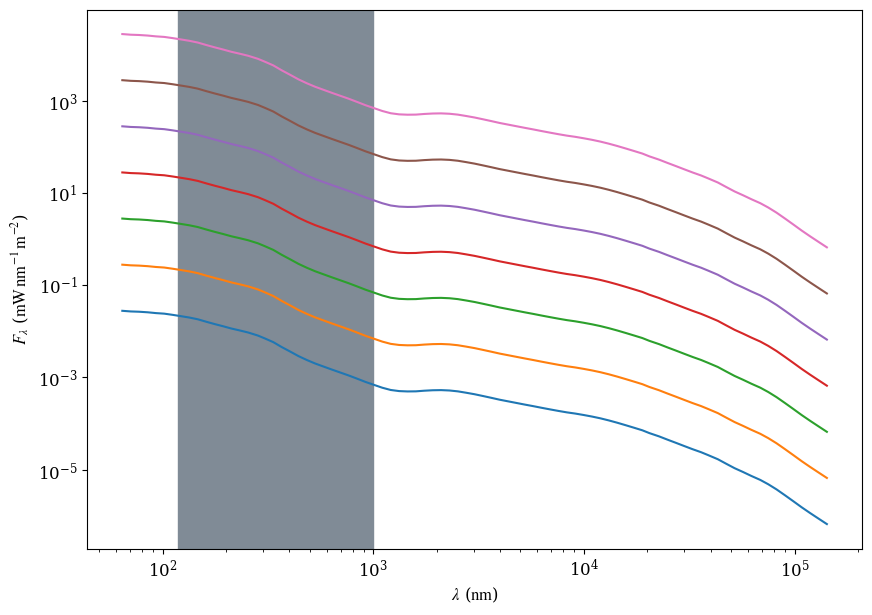

In [117]:
#these are flux curves (in appropriate units) that we inputted into PALEO

agn_fnu = agn_fnu.to(u.mW*(u.m**(-2))*(u.Hz**(-1)))
agn_nufnu = agn_fnu*agn_freq #recall that nuF_nu = lambdaF_lambda

agn_wav = c.c/(agn_freq)
agn_wav = agn_wav.to(u.nm)

agn_flambda = agn_nufnu/agn_wav #lambdaF_lambda/ lambda = F_lambda
# print(agn_flambda.unit) #this should be mW/m^2/nm, which it is

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question, determined above
for b in bolcorrs:
    plt.loglog(agn_wav,agn_flambda*b, label= b) #these are the curves to input into PALEO simulation
xunit_string = agn_wav.unit.to_string('latex_inline')
yunit_string = agn_flambda.unit.to_string('latex_inline')

plt.axvspan(117.72, 995.05, color="#808B96") #region of wavelengths PALEO actually uses

plt.xlabel("$\lambda$ ({})".format(xunit_string))
plt.ylabel("$F_\lambda$ ({})".format(yunit_string))


In [ ]:
# #saving the above as csv files we can input into PALEO-- run with caution

# # bolcorrs = 2.285226886530375*np.logspace(11,17,7)
# # #these correspond to fluxes 10, 100, ... 1e+7

# import csv

# index = 1
# for b in bolcorrs:
#     concat = np.concatenate((agn_wav.value, agn_flambda.value), axis=1)
#     concat[:,1] = concat[:,1]*b #the first row of concat is the flambda's
#     with open('PALEO_AGN_input_flux=e+'+str(index)+'.csv', 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile, delimiter='')
#         for c in range(0,np.shape(concat)[0]):
#             writer.writerow(concat[c,:])
#     index=index+1


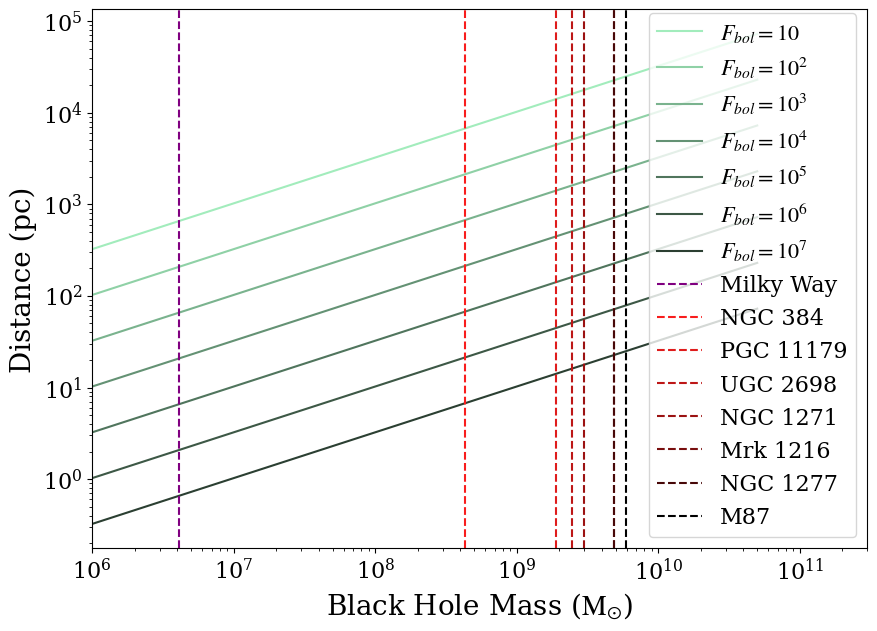

In [119]:
#Figure 7 (in appendix)

def radius_of_flux(flux, mbh, e_rat): #this is at 100% eddington
    L = Ledd(mbh)*e_rat
    L = L.to(u.erg*(u.s**(-1)))
    flux = flux.to(u.erg*(u.s**(-1)*(u.cm**(-2))))
    rsquared = L/(flux*4*np.pi)
    r = np.sqrt(rsquared)

    r = r.to(u.pc)

    return r

fluxes = np.logspace(1,7,7)*u.erg*(u.s**(-1))*(u.cm**(-2))
# fluxes

bh_masses = np.logspace(6,10.7,10)*u.M_sun
# bh_masses

colorlist=["#A2ECBC", "#8FD1A6", "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]

for n in range(0,7):
    flux = fluxes[n]
    plt.loglog(bh_masses[:], radius_of_flux(flux, bh_masses[:], 1), color=colorlist[n], label=clist[n])


plt.axvline(4.1e+6, color="purple", linestyle="dashed", label="Milky Way")

plt.axvline(4.34e+8, color="#F81D1D", linestyle="dashed", label="NGC 384") #9B1212
plt.axvline(1.91e+9, color="#DF1C1C", linestyle="dashed", label="PGC 11179") #DF1C1C
plt.axvline(2.46e+9, color="#BD1717", linestyle="dashed", label="UGC 2698") #780E0E
plt.axvline(3e+9, color="#9B1212", linestyle="dashed", label="NGC 1271") #BD1717
plt.axvline(4.9e+9, color="#780E0E", linestyle="dashed", label="Mrk 1216") #F81D1D
plt.axvline(4.9e+9, color="#470808", linestyle="dashed", label="NGC 1277")

plt.axvline(5.9e+9, color="black", linestyle="dashed", label="M87")


plt.xlim(1e+6,3e+11)

xunit_string = bh_masses.unit.to_string('latex_inline')

plt.xlabel("Black Hole Mass ({})".format(xunit_string),fontsize=20)
plt.ylabel("Distance (pc)",fontsize=20)
plt.tick_params(axis='both',labelsize=16)
plt.legend(loc='lower right', framealpha=0.8,fontsize=16)

# plt.savefig('/Users/sippy/Desktop/straightlines_'+str(date.today())+'.png')

# Plotting PALEO Simulation Outputs


In [120]:
# SET DEFAULT FOINT SIZE FOR PLOTTING 
mpl.rcParams['font.size'] = 14
mpl.rcParams["font.family"] = "serif"
csfont = {'fontname':'serif'}
plt.rcParams['mathtext.fontset']='stix'

from astropy import units as u, constants as c

In [121]:
path = "/Users/sippy/Desktop/Thesis/Rescaled PALEO outputs/"

fnames = [ #all modern files
   "PALEO_C2HONS_modern_init0816O2mr_2.1e-01_.nc",
    "PALEO_C2HONS_modern_init0816O2mr_2.1e-01_PALEO_AGN_input_flux=e+1.nc",
    "PALEO_C2HONS_modern_init0816O2mr_2.1e-01_PALEO_AGN_input_flux=e+2.nc",
    "PALEO_C2HONS_modern_init0816O2mr_2.1e-01_PALEO_AGN_input_flux=e+3.nc",
    "PALEO_C2HONS_modern_init0816O2mr_2.1e-01_PALEO_AGN_input_flux=e+4.nc",
    "PALEO_C2HONS_modern_init0816O2mr_2.1e-01_PALEO_AGN_input_flux=e+5.nc",
    "PALEO_C2HONS_modern_init0816_ftol=e-5O2mr_2.1e-01_PALEO_AGN_input_flux=e+6.nc",
    "PALEO_C2HONS_modern_init0816_ftol=5e-5O2mr_2.1e-01_PALEO_AGN_input_flux=e+7.nc", 
]

# fnames = [ #all proterozoic files
#    "PALEO_C2HONS_modern_init0816O2mr_1.0e-03_.nc", 
#     "PALEO_C2HONS_modern_init0816O2mr_1.0e-03_PALEO_AGN_input_flux=e+1.nc",
#     "PALEO_C2HONS_modern_init0816O2mr_1.0e-03_PALEO_AGN_input_flux=e+2.nc",
#     "PALEO_C2HONS_modern_init0816O2mr_1.0e-03_PALEO_AGN_input_flux=e+3.nc",
#     "PALEO_C2HONS_modern_init0816O2mr_1.0e-03_PALEO_AGN_input_flux=e+4.nc",
#     "PALEO_C2HONS_modern_init0816O2mr_1.0e-03_PALEO_AGN_input_flux=e+5.nc",
#     "PALEO_C2HONS_modern_init0816_ftol=e-6O2mr_1.0e-03_PALEO_AGN_input_flux=e+6.nc",
#     "PALEO_C2HONS_modern_init0816_ftol=5e-5O2mr_1.0e-03_PALEO_AGN_input_flux=e+7.nc",
# ]

# fnames = [ #all archean files
#    "PALEO_C2HONS_modern_init0816O2mr_1.0e-07_.nc", 
#     "PALEO_C2HONS_modern_init0816O2mr_1.0e-07_PALEO_AGN_input_flux=e+1.nc",
#     "PALEO_C2HONS_modern_init0816O2mr_1.0e-07_PALEO_AGN_input_flux=e+2.nc",
#     "PALEO_C2HONS_modern_init0816O2mr_1.0e-07_PALEO_AGN_input_flux=e+3.nc",
#     "PALEO_C2HONS_modern_init0816O2mr_1.0e-07_PALEO_AGN_input_flux=e+4.nc",
#     "PALEO_C2HONS_modern_init0816O2mr_1.0e-07_PALEO_AGN_input_flux=e+5.nc",
#     "PALEO_C2HONS_modern_init0816_ftol=5e-7O2mr_1.0e-07_PALEO_AGN_input_flux=e+6.nc", #10^7 didn't converge so only up to 10^6 flux
# ]

In [123]:
#there's 8 files, one wavelength data + 8 flux data = 9 col * 750 wavelength points worth of rows. 
#then TOA vs surface gives us 2 further dimensions. so (750 x 9 x 2)

#USING THIS CODE TO CREATE NUMPY ARRAYS OF FLUX VS WAVELENGTH (TOA AND SURFACE) SO I DONT HAVE TO KEEP PULLING FROM PALEO FILES/ CAN SAVE AS CSV

smean_data = {}
for fname in fnames:
    f = path+fname
    print(f)
    if os.path.exists(f):
        ds_atm = xr.open_dataset(f, group="atmtop") # top of atmosphere variables
        ds_atm = ds_atm.set_coords(["wgrid_wmid", "wgrid_wlower", "wgrid_wupper"]) # "zmid", "zlower", "zupper", 
        smean_data[fname] = ds_atm["flux_energy"] # takes top of atmosphere flux in W/m2/A


evolved_mod_TOA = np.zeros((750, 9)) #set to (750,8) for the Archean, (750,9) for others!
#this one is the TOA flux
for f in range(0,8): #7 for Archean, 8 for others
    fname = fnames[f]
    x = smean_data[fname].coords["wgrid_wmid"].values/10
    evolved_mod_TOA[:,0] = x #it will reassign these every time, but whatever they're all the same
    evolved_mod_TOA[:,f+1]= smean_data[fname]


smean_data = {}
reaction = "Smean"
for fname in fnames:
    f = path+fname
    if os.path.exists(f):
        ds_atm = xr.open_dataset(f, group="atm")
        # define coordinates within the data
        ds_atm = ds_atm.set_coords(["zmid", "zlower", "zupper", "wgrid_wmid", "wgrid_wlower", "wgrid_wupper"])  
        smean_data[fname] = ds_atm[reaction][-1]


evolved_mod_surf = np.zeros((750,9)) #likewise
#now the surface flux
for f in range(0,8):
    fname= fnames[f]
    x = smean_data[fname].coords["wgrid_wmid"].values/10
    evolved_mod_surf[:,0] = x #it will reassign these every time, but whatever they're all the same
    wratio = smean_data[fname].coords["wgrid_wupper"].values/smean_data[fname].coords["wgrid_wlower"].values
    wbins = (smean_data[fname].coords["wgrid_wupper"].values-smean_data[fname].coords["wgrid_wlower"].values)*1e-10
    flux = np.multiply(smean_data[fname][:,-1].data*1e4*c.h*c.c, np.log(wratio)/wbins)
    wbinsA = (smean_data[fname].coords["wgrid_wupper"].values-smean_data[fname].coords["wgrid_wlower"].values)
    flux = flux*1e3/wbinsA
    evolved_mod_surf[:,f+1]= flux

print(evolved_mod_TOA, evolved_mod_surf)

/Users/sippy/Desktop/Thesis/Rescaled PALEO outputs/PALEO_C2HONS_modern_init0816O2mr_2.1e-01_.nc
/Users/sippy/Desktop/Thesis/Rescaled PALEO outputs/PALEO_C2HONS_modern_init0816O2mr_2.1e-01_PALEO_AGN_input_flux=e+1.nc
/Users/sippy/Desktop/Thesis/Rescaled PALEO outputs/PALEO_C2HONS_modern_init0816O2mr_2.1e-01_PALEO_AGN_input_flux=e+2.nc
/Users/sippy/Desktop/Thesis/Rescaled PALEO outputs/PALEO_C2HONS_modern_init0816O2mr_2.1e-01_PALEO_AGN_input_flux=e+3.nc
/Users/sippy/Desktop/Thesis/Rescaled PALEO outputs/PALEO_C2HONS_modern_init0816O2mr_2.1e-01_PALEO_AGN_input_flux=e+4.nc
/Users/sippy/Desktop/Thesis/Rescaled PALEO outputs/PALEO_C2HONS_modern_init0816O2mr_2.1e-01_PALEO_AGN_input_flux=e+5.nc
/Users/sippy/Desktop/Thesis/Rescaled PALEO outputs/PALEO_C2HONS_modern_init0816_ftol=e-5O2mr_2.1e-01_PALEO_AGN_input_flux=e+6.nc
/Users/sippy/Desktop/Thesis/Rescaled PALEO outputs/PALEO_C2HONS_modern_init0816_ftol=5e-5O2mr_2.1e-01_PALEO_AGN_input_flux=e+7.nc
[[1.17720000e+02 5.40816000e-03 7.59575839e-0

In [11]:
#run with caution

# import csv
# with open('Evolved_Mod_TOA_'+str(date.today())+'.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile, delimiter=',')
#     for c in range(0,np.shape(evolved_mod_TOA)[0]):
#         writer.writerow(evolved_mod_TOA[c,:])

# with open('Evolved_Mod_Surf_'+str(date.today())+'.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile, delimiter=',')
#     for c in range(0,np.shape(evolved_mod_surf)[0]):
#         writer.writerow(evolved_mod_surf[c,:])

In [124]:
O3mr = {}
smean_data = {}
for fname in fnames:
    f = path+fname
    if os.path.exists(f):
        ds_atm = xr.open_dataset(f, group="atm")
        ds_atm = ds_atm.set_coords(["zmid", "zlower", "zupper", "wgrid_wmid", "wgrid_wlower", "wgrid_wupper"]) 
        O3mr[fname] = ds_atm["O3_mr"] # take ozone mixing ratio from file
        smean_data[fname] = ds_atm["Smean"] # take solar flux from file (in photons/cm2/s)

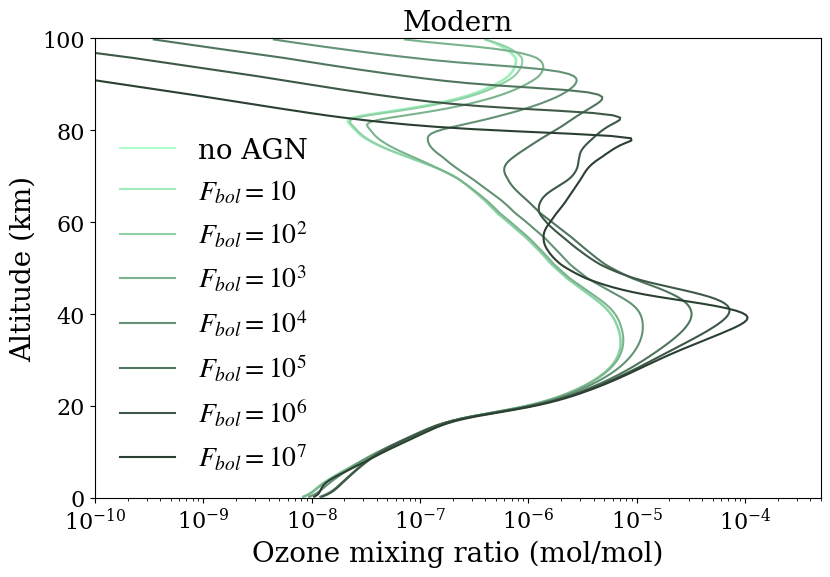

In [125]:
#one panel of Figure 2 (to be run once for each atm.)

colorlist=["#2B3F32", "#3D5846", "#50755D", "#649274", "#7AB38E", "#8FD1A6", "#A2ECBC", "#AEFFCB"]
clist=["$F_{bol} = 10^7$", "$F_{bol} = 10^6$","$F_{bol} = 10^5$", "$F_{bol} = 10^4$","$F_{bol} = 10^3$", "$F_{bol} = 10^2$", "$F_{bol} = 10$", "no AGN"]

fig = plt.figure(figsize=(16,6))

indexxx =7 #change to 6 for archean
ax=fig.add_subplot(121)
for fname in fnames:
    index = O3mr[fname].shape[0]-1 #this is indexing the time axis, choosing the final time in the series
    ax.plot(O3mr[fname][index], O3mr[fname].coords["zmid"].values/1000, color= colorlist[indexxx], label=clist[indexxx])
    indexxx=indexxx-1
    
ax.set_xlim([1e-10,5e-4])
ax.set_ylim([0,100])
ax.set_xscale('log')
ax.legend(frameon=False,fontsize=20)
ax.set_xlabel(r"Ozone mixing ratio (mol/mol)",fontsize=20)
ax.tick_params(axis='both',labelsize=16)
ax.set_xscale('log')
ax.set_ylabel(r"Altitude (km)", fontsize=20)
ax.set_title("Modern",fontsize=20)


plt.tight_layout()
plt.show()
# fig.savefig('/Users/sippy/Desktop/modozone'+str(date.today())+'.pdf')

In [126]:
#all below is to plot over time

O3mr = {}
smean_data = {}
for fname in ["PALEO_C2HONS_modern_init0816O2mr_1.0e-03_PALEO_AGN_input_flux=e+5.nc"]:
    f = path+fname
    if os.path.exists(f):
        ds_atm = xr.open_dataset(f, group="atm")
        ds_atm = ds_atm.set_coords(["zmid", "zlower", "zupper", "wgrid_wmid", "wgrid_wlower", "wgrid_wupper"]) 
        O3mr[fname] = ds_atm["O3_mr"] # take ozone mixing ratio from file
        # O3mr[fname] = ds_atm["O2_mr"] #change this to observe other molecules
        smean_data[fname] = ds_atm["Smean"] # take solar flux from file (in photons/cm2/s)

In [127]:
mod_TOA = np.loadtxt("/Users/sippy/Thesis/Evolved_Mod_TOA_08162024.csv", delimiter=",")
mod_surf = np.loadtxt("/Users/sippy/Thesis/Evolved_Mod_Surf_08162024.csv", delimiter=",")
    #[:,0] are wavelength in nm, rest are F_nu in mW/m^2/A
#use same 'wav' and 'freq' from previous
#8 columns in these files

wav = mod_TOA[:,0]*u.nm

freq = c.c/wav
freq = freq.to(u.Hz)


#turning the time plot arrays into numpy arrays so I can easily change them over to F_nu rather than F_lambda


time_array_flambda = np.zeros((750,16))*u.mW*(u.m**(-2))*(u.Angstrom**(-1)) #like one column of all the fluxes for each of 16 times. corresponding wavelengths are same as wav.

for t, i_t in zip(times[0:16], range(0,16)):
    x = smean_data[fname].coords["wgrid_wmid"].values/10
    wratio = smean_data[fname].coords["wgrid_wupper"].values/smean_data[fname].coords["wgrid_wlower"].values
    wbins = (smean_data[fname].coords["wgrid_wupper"].values-smean_data[fname].coords["wgrid_wlower"].values)*1e-10
    flux = np.multiply(smean_data[fname][i_t,:,-1].data*1e4*c.h*c.c, np.log(wratio)/wbins)
    wbinsA = (smean_data[fname].coords["wgrid_wupper"].values-smean_data[fname].coords["wgrid_wlower"].values)
    flux = flux*1e3/wbinsA
    flux = flux.value #the fact that i threw in astropy constants above messed with the units, but we know what it should come out to so just reset
    time_array_flambda[:,i_t] = flux*u.mW*(u.m**(-2))*(u.Angstrom**(-1)) #these are the units it comes in


time_array_flambda = time_array_flambda.to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.nm**(-1)))


time_array_lambdaflambda= np.zeros((750,16))
time_array_fnu = np.zeros((750,16))
for f in range(0,16):
    time_array_lambdaflambda[:,f] = wav*time_array_flambda[:,f] #recall lambda f_lambda = nu f_nu
    time_array_fnu[:,f] = time_array_lambdaflambda[:,f]/freq
    # print(time_array_fnu.unit) #it doesn't want to have units so whatever. but in any case I set the math up so it comes out to erg/s/cm^2/Hz
time_array_fnu= time_array_fnu*(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))



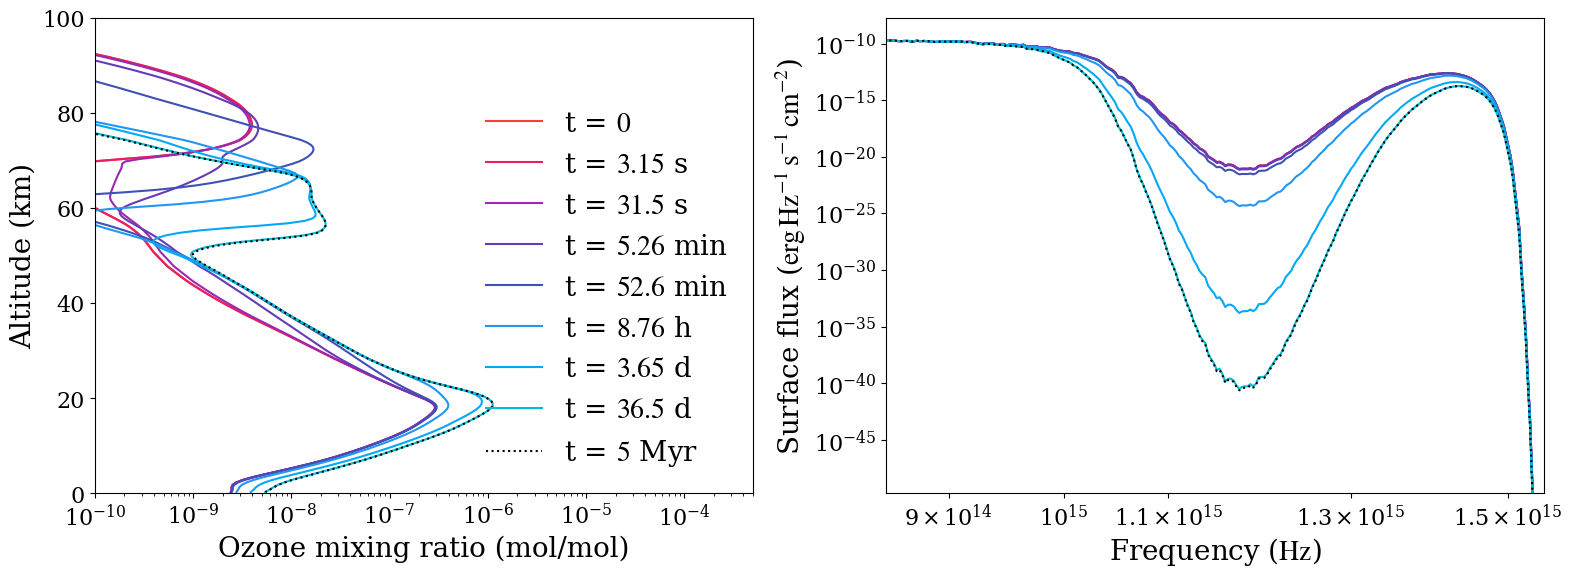

In [128]:
#Figure 3

from astropy import units as u, constants as c

fig = plt.figure(figsize=(16,6))

colorlist=["#F44336", "#E91E63", "#9C27B0", "#673AB7", "#3F51B5", "#2196F3", "#03A9F4", "#00BCD4", "#009688", "#4CAF50", "#8BC34A", "#CDDC39", "#FFEB3B", "#FFC107", "#FF9800", "#FF5722"]
timeslist=["t = $0$", "t = $3.15$ s", "t = $31.5$ s", "t = $5.26$ min", "t = $52.6$ min", "t = $8.76$ h", "t = $3.65$ d", "t = $36.5$ d", "t = $1$ yr", "t = $10$ yr", "t = $10^2$ yr", "t = $10^3$ yr", "t = $10^4$ yr", "t = $10^5$ yr", "t = $10^6$ yr", "t = $5$ Myr"]

ax=fig.add_subplot(121)
times = O3mr[fname].coords["tmodel"].values
for t, i_t in zip(times[0:8], range(0,8)): # change this if you want all the times, there are 16 total in a full run, switch to 'len(times)'
    ax.plot(O3mr[fname][i_t], O3mr[fname].coords["zmid"].values/1000, color= colorlist[i_t], label=timeslist[i_t])
    
ax.plot(O3mr[fname][15], O3mr[fname].coords["zmid"].values/1000, linestyle="dotted", color= "black", label=timeslist[15])

ax.set_xlim([1e-10,5e-4])
ax.set_ylim([0,100])
ax.set_xscale('log')
ax.legend(loc= 'lower right', frameon=False, fontsize=20)
ax.set_xlabel(r"Ozone mixing ratio (mol/mol)",fontsize=20)
ax.set_ylabel(r"Altitude (km)",fontsize=20)
ax.tick_params(axis='both',labelsize=16)

ax=fig.add_subplot(122)


for t, i_t in zip(times[0:8], range(0,8)):
    plt.plot(freq, time_array_fnu[:,i_t].value, color= colorlist[i_t], label=timeslist[i_t]) #this will index each column which corresponds to each time.

plt.plot(freq, time_array_fnu[:,15].value, linestyle="dotted", color="black", label=timeslist[15])

yunit_string = time_array_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

ax.set_yscale("log")
ax.set_xscale('log')
ax.set_xlabel("Frequency ({})".format(xunit_string),fontsize=20)
ax.set_ylabel("Surface flux ({})".format(yunit_string),fontsize=20)
ax.tick_params(axis='both',labelsize=16)
ax.set_xticks([9e+14,1e+15,1.1e+15,1.3e+15,1.5e+15])
ax.set_xticks([],minor=True)
ax.set_xlim(8.5e+14, 1.55e+15)
ax.set_ylim(2e-50,2e-8)

plt.tight_layout()
plt.show()
# fig.savefig('/Users/sippy/Desktop/timeevofnu'+str(date.today())+'.pdf')

# Before and after atm. evolution plots

In [20]:
from astropy import units as u, constants as c


agn_sed = np.loadtxt("/Users/sippy/Thesis/quasar SED.csv", delimiter =",")
#mean quasar SED from Richards et al. 2006 fig 9, [:,0] is log(frequency) in log(Hz), [:,1] is F_\nu microJy
#reloading this so I know what units it's in

agn_freq = agn_sed[:,0]*u.dex(u.Hz)
agn_fnu = agn_sed[:,1]*u.uJy

agn_freq = agn_freq.to(u.Hz)
agn_fnu = agn_fnu.to(u.erg*(u.cm**(-2))*(u.s**(-1))*(u.Hz**(-1)))


In [72]:
#DANGER LIMITS TO SPECIES

humans = np.loadtxt("/Users/sippy/Thesis/humans.csv", delimiter=",")
#[:,0] is wavelength in nm, [:,1] is dose to kill 50% of cells in mJ/cm^2
#they did 48 hr but we'll use standard time of 24h, as done previously
#this comes from Aoki et al. (2011) "Ultravoilet Action Spectrum and Effect of EPC-K1 on Ultraviolet Radiation-induced Injury in Cultured Normal Human Epidermal Keratinocytes"
human_wav = humans[:,0]*u.nm
human_flux = humans[:,1]*u.mJ*(u.cm**(-2))

human_flux = human_flux/(24*u.hour)
human_flux = human_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))

human_freq = c.c/human_wav
human_freq = human_freq.to(u.Hz)

human_flambda = human_flux/(10*u.nm) #10 nm bandwidth for each wavelength of light exposed
human_lambdaflambda = human_wav*human_flambda #recall this = nu F_nu
human_fnu = human_lambdaflambda/human_freq
human_fnu = human_fnu.to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))


rats = np.loadtxt("/Users/sippy/Thesis/MasumaRats.csv", delimiter=",")
#this comes from Masuma et al. (2013) "Effects of UV wavelength on cell damages caused by UV irradiation in PC12 cells"

rat_wav = rats[:,0]*u.nm

rat_flux = rats[:,1]*u.mJ*(u.cm**(-2))/(24*u.hour)
rat_flux = rat_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))

rat_freq = c.c/rat_wav
rat_freq = rat_freq.to(u.Hz)

rat_flambda = rat_flux/(10*u.nm) #10 nm bandwith for each wavelength of light used
rat_lambdaflambda = rat_wav*rat_flambda #recall lambda F_lambda = nu F_nu
rat_fnu = rat_lambdaflambda/(rat_freq) 



ecol_survival = np.loadtxt("/Users/sippy/Thesis/Ecol Survival.csv", delimiter=",")
drad_survival = np.loadtxt("/Users/sippy/Thesis/Drad Survival.csv", delimiter=",")
#from Krisko & Radman (2010) "Protein damage and death by radiation in Escherichia coli and Deinococcus radiodurans"

ecol_flux = ecol_survival[:,0]*u.J*(u.m**(-2))/(24*u.hour)
drad_flux = drad_survival[:,0]*u.J*(u.m**(-2))/(24*u.hour)

ecol_flux = ecol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
drad_flux = drad_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))

microbe_wav = 260*u.nm
microbe_wav_min = 255*u.nm #bandwidth is 10 nm
microbe_wav_max = 265*u.nm

microbe_freq = c.c/microbe_wav
microbe_freq = microbe_freq.to(u.Hz)
microbe_freq_min = c.c/microbe_wav_min
microbe_freq_min = microbe_freq_min.to(u.Hz)
microbe_freq_max = c.c/microbe_wav_max
microbe_freq_max = microbe_freq_max.to(u.Hz)

ecol_flambda = ecol_flux/(10*u.nm) 
drad_flambda = drad_flux/(10*u.nm)

ecol_lambdaflambda = microbe_wav*ecol_flambda
drad_lambdaflambda = microbe_wav*drad_flambda

ecol_fnu = ecol_lambdaflambda/microbe_freq
drad_fnu = drad_lambdaflambda/microbe_freq

ecol_fnu = ecol_fnu.to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))
drad_fnu = drad_fnu.to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))

ecol_survive = ecol_survival[:,1]
drad_survive = drad_survival[:,1]

f = sc.interp1d(ecol_survive, ecol_fnu)
ecol_lethalfnu = f(0.5) #where 50% of cells are killed (to make it same as other 2 papers)

f = sc.interp1d(drad_survive, drad_fnu)
drad_lethalfnu = f(0.5) #likewise

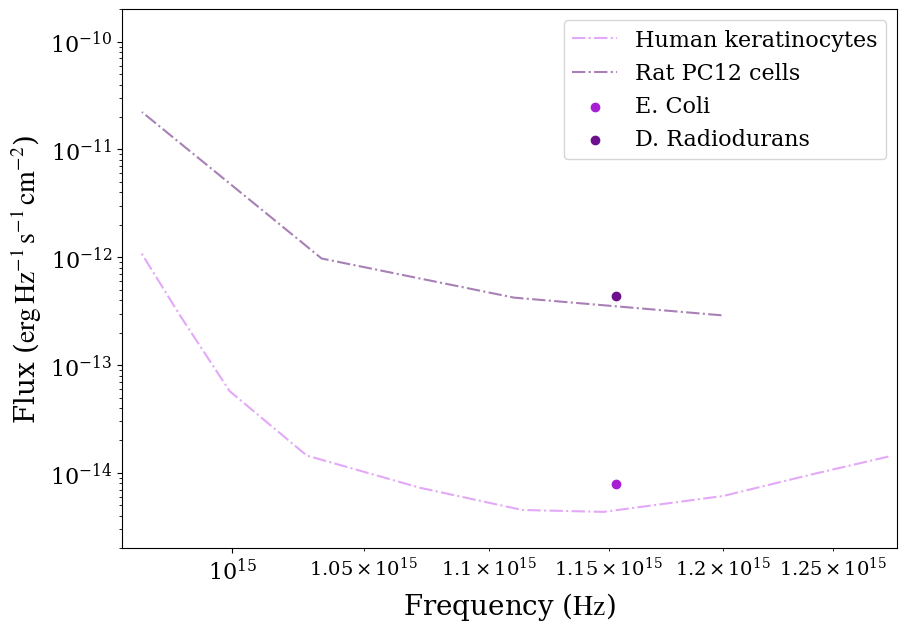

In [73]:
#panel 1/2 of Figure 8 (appendix)

plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#E4A8F8", label="Human keratinocytes")
plt.loglog(rat_freq, rat_fnu, linestyle="dashdot", color="#A880B5", label="Rat PC12 cells")
plt.scatter(microbe_freq, ecol_lethalfnu, color="#A61FD4", label="E. Coli")
plt.scatter(microbe_freq, drad_lethalfnu, color="#6D108C", label="D. Radiodurans")

yunit_string = human_fnu.unit.to_string('latex_inline')
xunit_string = human_freq.unit.to_string('latex_inline')

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)
plt.tick_params(axis='both',labelsize=16)

plt.xlim(9.6e+14, 1.28e+15)
plt.ylim(2e-15,2e-10)

plt.legend(fontsize=16)

# plt.savefig('/Users/sippy/Desktop/species_'+str(date.today())+'.png')

In [74]:
#extrapolate and make all about the same shape as humans

f = sc.interp1d(human_freq, human_fnu) #match a frequency onto the F_nu lethal to humans
ff = sc.interp1d(rat_freq, rat_fnu) #likewise for rats

sep_ecol = ecol_lethalfnu/f(microbe_freq) 

ecol_fnu_extrap = np.zeros((10,))*rat_fnu.unit
for m in range(0,10):
    val = human_fnu[m].value*sep_ecol #same eqn as above, rearranged to solve for the corresponding ecol_fnu value
    ecol_fnu_extrap[m] = val* rat_fnu.unit

#now the same for d. rad
sep_drad = drad_lethalfnu/f(microbe_freq) #ratio between drad and rats bc i realized this is better

drad_fnu_extrap = np.zeros((10,))*rat_fnu.unit
for m in range(0,10):
    val = human_fnu[m].value* sep_drad #same eqn as above, rearranged to solve for the corresponding ecol_fnu value
    drad_fnu_extrap[m] = val* rat_fnu.unit

sep_rat = np.average(rat_fnu.value/(f(rat_freq))) #divide the rat F_nu by the F_nu at same freq. on humans

extra_point_fr = np.array(([human_freq[0].value]))*u.Hz
rat_freq_extrap = np.concatenate((extra_point_fr, rat_freq))

extra_point_fnu = np.array(([sep_rat*human_fnu[0].value]))*rat_fnu.unit
rat_fnu_extrap = np.concatenate((extra_point_fnu, rat_fnu))

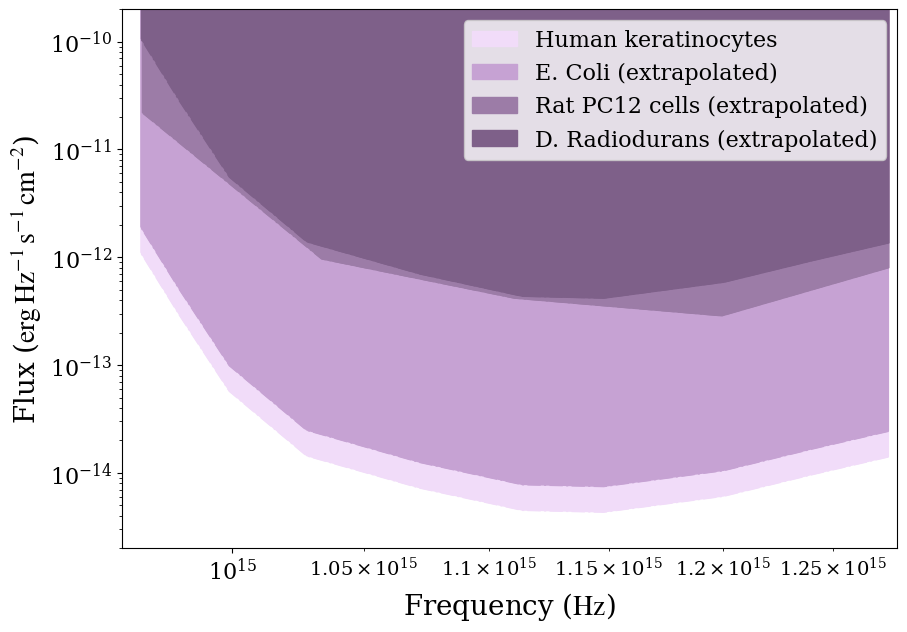

In [75]:
#panel 2/2 of Figure 8 (appendix)

plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9") #"#BC22F1"
plt.fill_between(human_freq.value, human_fnu.value, 1e-7, color="#F1DCF9", label="Human keratinocytes")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3") #"#A61FD4"
plt.fill_between(human_freq.value, ecol_fnu_extrap[:], 1e-7, color="#C6A2D3", label="E. Coli (extrapolated)")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7") #"#8F1CB6"
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 1e-7, color = "#9C7CA7", label="Rat PC12 cells (extrapolated)")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089") #"#6D108C"
plt.fill_between(human_freq.value, drad_fnu_extrap[:], 1e-7, color="#7E6089", label="D. Radiodurans (extrapolated)")

yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)
plt.tick_params(axis='both',labelsize=16)

plt.xlim(9.6e+14, 1.28e+15)
plt.ylim(2e-15,2e-10)

plt.legend(fontsize=16)

# plt.savefig('/Users/sippy/Desktop/species_extrap_'+str(date.today())+'.png')

In [23]:
mod_TOA = np.loadtxt("/Users/sippy/Thesis/Evolved_Mod_TOA_08162024.csv", delimiter=",")
mod_surf = np.loadtxt("/Users/sippy/Thesis/Evolved_Mod_Surf_08162024.csv", delimiter=",")
    #[:,0] are wavelength in nm, rest are F_nu in mW/m^2/A
#use same 'wav' and 'freq' from previous
#8 columns in these files

wav = mod_TOA[:,0]*u.nm

freq = c.c/wav
freq = freq.to(u.Hz)

mod_flambda = mod_surf[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1)) #now 6 columns remaining, cutting off the wavelength
mod_flambda = mod_flambda.to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.nm**(-1)))


mod_lambdaflambda = np.zeros((750,8))
mod_fnu = np.zeros((750,8))
for f in range(0,8):
    mod_lambdaflambda[:,f] = wav*mod_flambda[:,f] #recall lambda f_lambda = nu f_nu
    mod_fnu[:,f] = mod_lambdaflambda[:,f]/freq
    # prot_fnu[:,f] = prot_fnu[:,f].to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))
#^ this doesn't work for the big array but i set up the units earlier so it should come out in erg/s/cm^2/Hz regardless...
mod_fnu= mod_fnu*(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))


mod_flambda_TOA = mod_TOA[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
mod_flambda_TOA = mod_flambda_TOA.to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.nm**(-1)))

mod_lambdaflambda_TOA = np.zeros((750,8))
mod_fnu_TOA = np.zeros((750,8))
for f in range(0,8):
    mod_lambdaflambda_TOA[:,f] = wav*mod_flambda_TOA[:,f] #recall lambda f_lambda = nu f_nu
    mod_fnu_TOA[:,f] = mod_lambdaflambda_TOA[:,f]/freq
    # prot_fnu[:,f] = prot_fnu[:,f].to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))
#^ this doesn't work for the big array but i set up the units earlier so it should come out in erg/s/cm^2/Hz regardless...
mod_fnu_TOA= mod_fnu_TOA*(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))


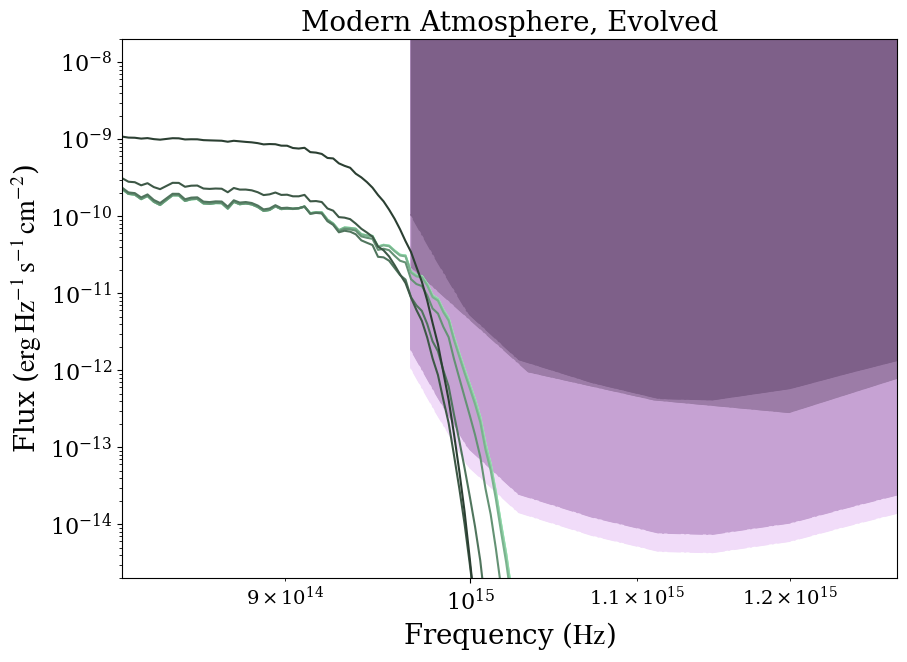

In [24]:
#panel 1/6 of Figure 4

colorlist=["#AEFFCB", "#A2ECBC", "#8FD1A6", "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["No AGN", "$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]

plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap, 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap, 2e-5, color="#7E6089", label="Danger to D. Radiodurans")

for f in range(0,8):
    plt.loglog(freq, mod_fnu[:,f], color=colorlist[f],label = clist[f])

yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-15,2e-8)

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)
plt.title("Modern Atmosphere, Evolved",fontsize=20)
plt.tick_params(axis='both',labelsize=16)

# plt.legend(loc="lower left", fontsize=20)

# plt.savefig('/Users/sippy/Desktop/mod_evolved_sbs_'+str(date.today())+'.png')

In [25]:

def limitedintegrate(integrand,dx,limit,dx_lim): #this is to get Fig 5 (the red and black lines) later
    #interpolates and then integrates how much flux is above a given curve (the limit and dx_lim)

    f = interp1d(np.log10(dx_lim.value),np.log10(limit.value),bounds_error=False) #match a frequency on to a limit flux (interpolate in log space)
    limit_interp = (10**(f(np.log10(dx.value))))*limit.unit #resulting version of limit fluxes (w appropriate units)

    limit_interp = np.nan_to_num(limit_interp,copy=False) #change all nans to zeros


    adjusted_integrand = np.zeros((np.shape(integrand)))*integrand.unit
    for m in range(0,np.shape(integrand)[0]): #they should all have the same shape now
        if limit_interp[m].value == 0: #get rid of all the values in the AGN curves that are outside of the purple region frequencies
            adjusted_integrand[m] = 0
        elif integrand[m] <= limit_interp[m]: #set the parts below the limiting curve to actually be = to it, so those parts of integral will come out to zero
            adjusted_integrand[m] = limit_interp[m]
        else:
            adjusted_integrand[m] = integrand[m]

    arealim = -np.trapz(limit_interp,dx)
    areaint = -np.trapz(adjusted_integrand,dx)

    enclosed_area = areaint-arealim

    return enclosed_area



area_mod_evolved = np.zeros((8,4))*u.erg*(u.s**(-1))*(u.cm**(-2))
for i in range(0,8): #from lowest to greatest flux
        area_mod_evolved[i,0] = limitedintegrate(mod_fnu[:,i],freq,human_fnu,human_freq) #column 0 is humans
        area_mod_evolved[i,2] = limitedintegrate(mod_fnu[:,i],freq,rat_fnu_extrap,rat_freq_extrap) #column 1 is rats
        area_mod_evolved[i,1] = limitedintegrate(mod_fnu[:,i],freq,ecol_fnu_extrap,human_freq) #column 2 is ecoli
        area_mod_evolved[i,3] = limitedintegrate(mod_fnu[:,i],freq,drad_fnu_extrap,human_freq) #column 3 is drad

print(area_mod_evolved)

[[293.0817274  283.3286523    0.           0.        ]
 [292.93212012 283.17904501   0.           0.        ]
 [291.59500204 281.84192694   0.           0.        ]
 [279.06972486 269.32733784   0.           0.        ]
 [202.28941871 192.68302321   0.           0.        ]
 [ 83.60552054  74.57021837   0.           0.        ]
 [ 62.9770714   54.47513915   0.           0.        ]
 [248.14524825 239.36849472   7.71302005   0.        ]] erg / (s cm2)


In [26]:
protero_TOA = np.loadtxt("/Users/sippy/Thesis/Evolved_Prot_TOA_08062024.csv", delimiter=",")
protero_surf = np.loadtxt("/Users/sippy/Thesis/Evolved_Prot_Surf_08062024.csv", delimiter=",")
    #[:,0] are wavelength in nm, rest are F_nu in mW/m^2/A

prot_flambda = protero_surf[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
prot_flambda = prot_flambda.to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.nm**(-1)))

prot_lambdaflambda = np.zeros((750,8))
prot_fnu = np.zeros((750,8))
for f in range(0,8):
    prot_lambdaflambda[:,f] = wav*prot_flambda[:,f] #recall lambda f_lambda = nu f_nu
    prot_fnu[:,f] = prot_lambdaflambda[:,f]/freq
    # prot_fnu[:,f] = prot_fnu[:,f].to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))
#^ this doesn't work for the big array but i set up the units earlier so it should come out in erg/s/cm^2/Hz regardless...
prot_fnu= prot_fnu*(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))


prot_flambda_TOA = protero_TOA[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
prot_flambda_TOA = prot_flambda_TOA.to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.nm**(-1)))
prot_lambdaflambda_TOA = np.zeros((750,8))
prot_fnu_TOA = np.zeros((750,8))
for f in range(0,8):
    prot_lambdaflambda_TOA[:,f] = wav*prot_flambda_TOA[:,f] #recall lambda f_lambda = nu f_nu
    prot_fnu_TOA[:,f] = prot_lambdaflambda_TOA[:,f]/freq
    # prot_fnu[:,f] = prot_fnu[:,f].to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))
#^ this doesn't work for the big array but i set up the units earlier so it should come out in erg/s/cm^2/Hz regardless...
prot_fnu_TOA= prot_fnu_TOA*(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))


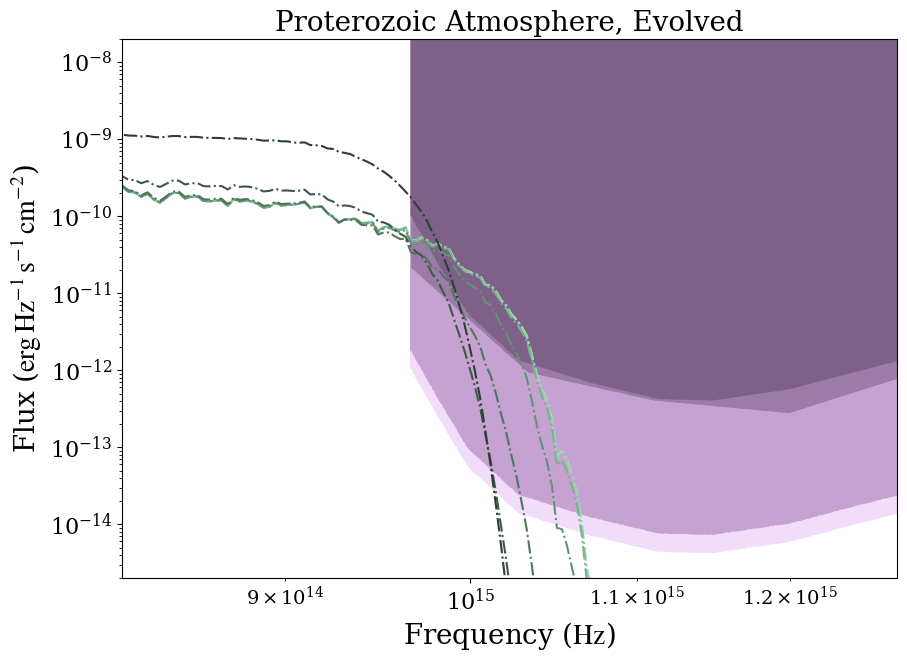

In [27]:
#panel 2/6 of Figure 4

colorlist=["#AEFFCB", "#A2ECBC", "#8FD1A6", "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["No AGN", "$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]

plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap, 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap, 2e-5, color="#7E6089", label="Danger to D. Radiodurans")

for f in range(0,8):
    plt.loglog(freq, prot_fnu[:,f], color = colorlist[f], linestyle="dashdot", label= clist[f])

yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-15,2e-8)

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)
plt.title("Proterozoic Atmosphere, Evolved",fontsize=20)
plt.tick_params(axis='both',labelsize=16)

# plt.legend(loc="lower left", fontsize=20)

# plt.savefig('/Users/sippy/Desktop/prot_evolved_sbs_'+str(date.today())+'.png')

In [28]:
area_prot_evolved = np.zeros((8,4))*u.erg*(u.s**(-1))*(u.cm**(-2)) #same setup as w modern atm
for i in range(0,8):
        area_prot_evolved[i,0] = limitedintegrate(prot_fnu[:,i],freq,human_fnu,human_freq)
        area_prot_evolved[i,2] = limitedintegrate(prot_fnu[:,i],freq,rat_fnu_extrap,rat_freq_extrap)
        area_prot_evolved[i,1] = limitedintegrate(prot_fnu[:,i],freq,ecol_fnu_extrap,human_freq)
        area_prot_evolved[i,3] = limitedintegrate(prot_fnu[:,i],freq,drad_fnu_extrap,human_freq)

print(area_prot_evolved)

[[1669.90744696 1659.63128743 1109.70673686  624.09551843]
 [1669.37829781 1659.10224825 1109.20650033  623.63430523]
 [1664.6344818  1654.35940384 1104.72121803  619.4996148 ]
 [1618.97629143 1608.70718481 1061.49094969  579.71383209]
 [1299.91895155 1289.75072969  759.74298785  315.0157849 ]
 [ 683.36764466  673.37073979  228.54952303    0.        ]
 [ 559.2804485   549.5273734   142.43277144    0.        ]
 [2088.66001664 2078.90694154 1234.71619167  866.66785485]] erg / (s cm2)


In [29]:
arch_TOA = np.loadtxt("/Users/sippy/Thesis/Evolved_Arch_TOA_08062024.csv", delimiter=",")
arch_surf = np.loadtxt("/Users/sippy/Thesis/Evolved_Arch_Surf_08062024.csv", delimiter=",")
    #[:,0] are wavelength in nm, rest are F_nu in mW/m^2/A
#use same 'wav' and 'freq' from previous

arch_flambda = arch_surf[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
arch_flambda = arch_flambda.to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.nm**(-1)))

arch_lambdaflambda = np.zeros((750,7))
arch_fnu = np.zeros((750,7))
for f in range(0,7):
    arch_lambdaflambda[:,f] = wav*arch_flambda[:,f] #recall lambda f_lambda = nu f_nu
    arch_fnu[:,f] = arch_lambdaflambda[:,f]/freq
    # prot_fnu[:,f] = prot_fnu[:,f].to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))
#^ this doesn't work for the big array but i set up the units earlier so it should come out in erg/s/cm^2/Hz regardless...
arch_fnu= arch_fnu*(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))


arch_flambda_TOA = arch_TOA[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
arch_flambda_TOA = arch_flambda_TOA.to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.nm**(-1)))

arch_lambdaflambda_TOA = np.zeros((750,7))
arch_fnu_TOA = np.zeros((750,7))
for f in range(0,7):
    arch_lambdaflambda_TOA[:,f] = wav*arch_flambda_TOA[:,f] #recall lambda f_lambda = nu f_nu
    arch_fnu_TOA[:,f] = arch_lambdaflambda_TOA[:,f]/freq
    # prot_fnu[:,f] = prot_fnu[:,f].to(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))
#^ this doesn't work for the big array but i set up the units earlier so it should come out in erg/s/cm^2/Hz regardless...
arch_fnu_TOA= arch_fnu_TOA*(u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1)))


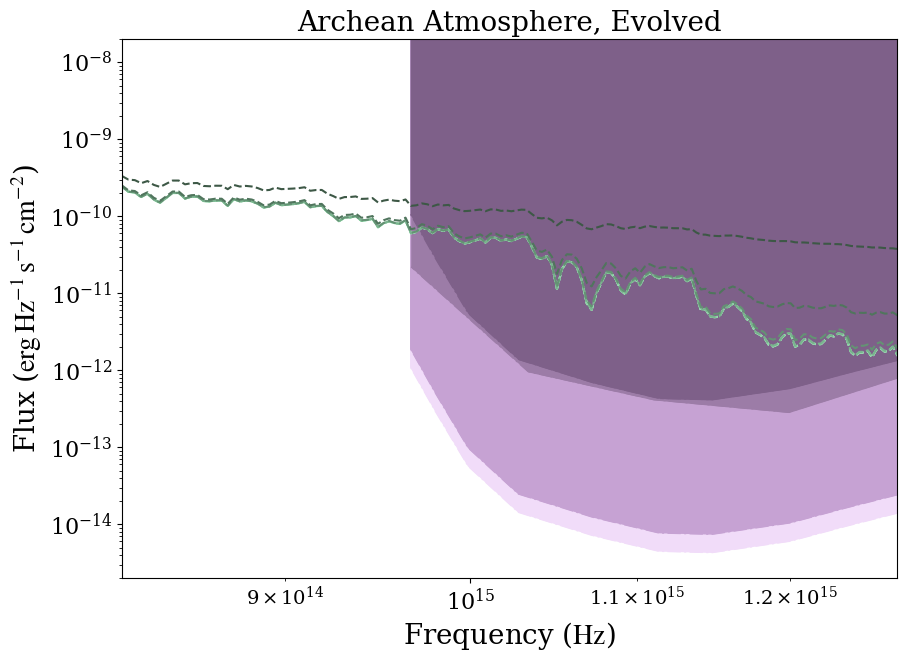

In [30]:
#panel 3/6 of Figure 4

colorlist=["#AEFFCB", "#A2ECBC", "#8FD1A6", "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["No AGN", "$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]

plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap, 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap, 2e-5, color="#7E6089", label="Danger to D. Radiodurans")

for f in range(0,7):
    plt.loglog(freq, arch_fnu[:,f], color=colorlist[f], linestyle="dashed", label = clist[f])

yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-15,2e-8)

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)
plt.title("Archean Atmosphere, Evolved",fontsize=20)
plt.tick_params(axis='both',labelsize=16)

# plt.legend(loc="lower left", fontsize=20)

# plt.savefig('/Users/sippy/Desktop/arch_evolved_sbs_1113.png')

In [31]:
area_arch_evolved = np.zeros((7,4))*u.erg*(u.s**(-1))*(u.cm**(-2))
for i in range(0,7):
        area_arch_evolved[i,0] = limitedintegrate(arch_fnu[:,i],freq,human_fnu,human_freq)
        area_arch_evolved[i,2] = limitedintegrate(arch_fnu[:,i],freq,rat_fnu_extrap,rat_freq_extrap)
        area_arch_evolved[i,1] = limitedintegrate(arch_fnu[:,i],freq,ecol_fnu_extrap,human_freq)
        area_arch_evolved[i,3] = limitedintegrate(arch_fnu[:,i],freq,drad_fnu_extrap,human_freq)

print(area_arch_evolved)

[[ 6067.55707217  6056.2135145   5360.90382759  4760.57614514]
 [ 6067.73350354  6056.38994587  5361.07792008  4760.74788811]
 [ 6069.32066493  6057.97710726  5362.64404119  4762.29286984]
 [ 6085.1490571   6073.80549943  5378.26241209  4777.70040562]
 [ 6242.32672876  6230.98317109  5533.35311228  4930.70477562]
 [ 7803.15927868  7791.81572101  7073.42709642  6450.11016537]
 [23350.75934845 23339.41579078 22413.6266622  21854.39356142]] erg / (s cm2)


In [32]:
#NOW MAKING THE INITIAL ATM. PLOTS/ BEFORE AGN AFFECTS THINGS

protero_TOA = np.loadtxt("/Users/sippy/Thesis/Evolved_Prot_TOA_08162024.csv", delimiter=",")
protero_surf = np.loadtxt("/Users/sippy/Thesis/Evolved_Prot_Surf_08162024.csv", delimiter=",")
    #[:,0] are wavelength in nm, rest are F_nu in mW/m^2/A

prot_flambda = protero_surf[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
prot_TOA_flambda = protero_TOA[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
#i'll just ratio the flambda since it's all the same thing

prot_trans = prot_flambda[:,0]/prot_TOA_flambda[:,0] #the [:,0] are the no agn case
#percentage of radiation that gets through as a fcn of wavelength in the original/ no AGN proterozoic atm.

sun_surf_fnu_prot = prot_fnu[:,0] #just the sun's radiation on the surface, saving to add to AGN radiation for initial atms.

arch_TOA = np.loadtxt("/Users/sippy/Thesis/Evolved_Arch_TOA_08162024.csv", delimiter=",")
arch_surf = np.loadtxt("/Users/sippy/Thesis/Evolved_Arch_Surf_08162024.csv", delimiter=",")
    #[:,0] are wavelength in nm, rest are F_nu in mW/m^2/A

arch_flambda = arch_surf[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
arch_TOA_flambda = arch_TOA[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
#i'll just ratio the flambda since it's all the same thing

arch_trans = arch_flambda[:,0]/arch_TOA_flambda[:,0] #the [:,0] are the no agn case
#percentage of radiation that gets through as a fcn of wavelength in the original/ no AGN archean atm.

sun_surf_fnu_arch = arch_fnu[:,0]

mod_TOA = np.loadtxt("/Users/sippy/Thesis/Evolved_Mod_TOA_08162024.csv", delimiter=",")
mod_surf = np.loadtxt("/Users/sippy/Thesis/Evolved_Mod_Surf_08162024.csv", delimiter=",")
    #[:,0] are wavelength in nm, rest are F_nu in mW/m^2/A

mod_flambda = mod_surf[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
mod_TOA_flambda = mod_TOA[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
#i'll just ratio the flambda since it's all the same thing

mod_trans = mod_flambda[:,0]/mod_TOA_flambda[:,0] #the [:,0] are the no agn case
#percentage of radiation that gets through as a fcn of wavelength in the original/ no AGN modern atm.

sun_surf_fnu_mod = mod_fnu[:,0]

In [33]:
f = sc.interp1d(agn_freq, agn_fnu, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
agn_fnufilt_prot = np.zeros(np.shape(prot_trans))
for n in range(0,np.shape(prot_trans)[0]):
    match = f(freq[n]) #find AGN SED flux corr. to the freq 
    agn_fnufilt_prot[n] = match*prot_trans[n] #multiply by fraction that is allowed to mass through atm.
agn_fnufilt_prot = agn_fnufilt_prot*agn_fnu.unit #later we will multiply these by bolometric corrections to get the actual flux

f = sc.interp1d(agn_freq, agn_fnu, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
agn_fnufilt_arch = np.zeros(np.shape(arch_trans))
for n in range(0,np.shape(arch_trans)[0]):
    match = f(freq[n]) #find sed flux corr. to the freq 
    agn_fnufilt_arch[n] = match*arch_trans[n]
agn_fnufilt_arch = agn_fnufilt_arch*agn_fnu.unit

f = sc.interp1d(agn_freq, agn_fnu, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
agn_fnufilt_mod = np.zeros(np.shape(mod_trans))
for n in range(0,np.shape(mod_trans)[0]):
    match = f(freq[n]) #find sed flux corr. to the freq 
    agn_fnufilt_mod[n] = match*mod_trans[n]
agn_fnufilt_mod = agn_fnufilt_mod*agn_fnu.unit

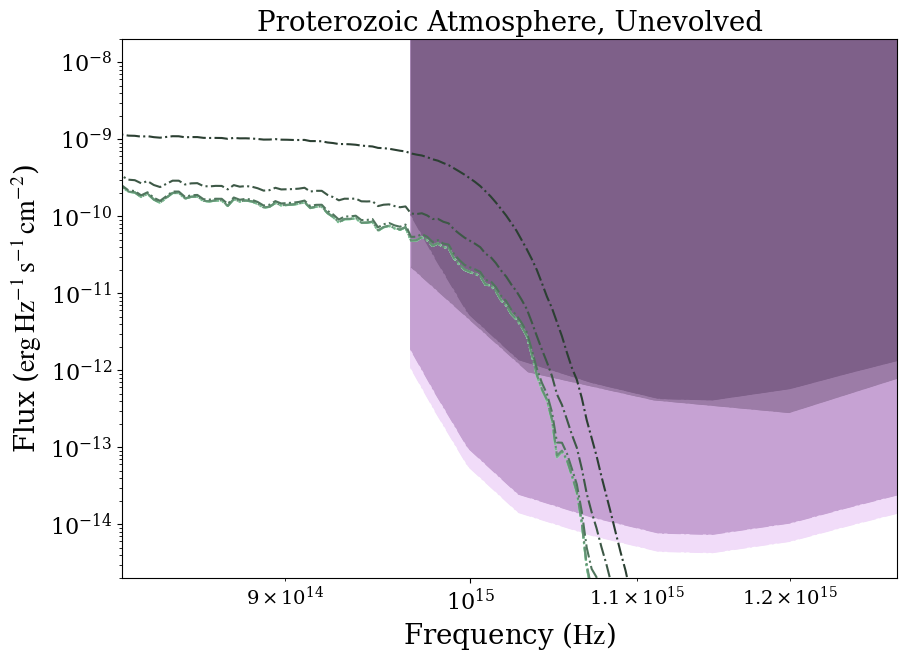

In [34]:
#panel 4/6 of Figure 4


colorlist=["#A2ECBC", "#8FD1A6", "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]


plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap, 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap, 2e-5, color="#7E6089", label="Danger to D. Radiodurans")

plt.loglog(freq, sun_surf_fnu_prot, linestyle="dashdot", color="#AEFFCB", label="No AGN")

index=0
bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question
for b in bolcorrs:
    plt.loglog(freq, (agn_fnufilt_prot*b)+sun_surf_fnu_prot, linestyle="dashdot", color= colorlist[index], label=clist[index])
    index=index+1

yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-15,2e-8)

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)
plt.title("Proterozoic Atmosphere, Unevolved",fontsize=20)
plt.tick_params(axis='both',labelsize=16)

# plt.legend(loc="lower left", fontsize=20)

# plt.savefig('/Users/sippy/Desktop/prot_unevolved_sbs_'+str(date.today())+'.png')

In [35]:
area_prot_unevolved = np.zeros((8,4))*u.erg*(u.s**(-1))*(u.cm**(-2))

bolcorrs = np.concatenate(([0],2.285226886530375*np.logspace(11,17,7))) #bol corrs in question
for i in range(0,8):
        area_prot_unevolved[i,0] = limitedintegrate((agn_fnufilt_prot*bolcorrs[i])+sun_surf_fnu_prot,freq,human_fnu,human_freq)
        area_prot_unevolved[i,2] = limitedintegrate((agn_fnufilt_prot*bolcorrs[i])+sun_surf_fnu_prot,freq,rat_fnu_extrap,rat_freq_extrap)
        area_prot_unevolved[i,1] = limitedintegrate((agn_fnufilt_prot*bolcorrs[i])+sun_surf_fnu_prot,freq,ecol_fnu_extrap,human_freq)
        area_prot_unevolved[i,3] = limitedintegrate((agn_fnufilt_prot*bolcorrs[i])+sun_surf_fnu_prot,freq,drad_fnu_extrap,human_freq)

print(area_prot_unevolved)

[[ 1669.90744696  1659.63128743  1109.70673686   624.09551843]
 [ 1669.92862579  1659.65246497  1109.72591313   624.11124137]
 [ 1670.11923526  1659.84306285  1109.89849953   624.25274775]
 [ 1672.02532989  1661.74904167  1111.62436348   625.66781161]
 [ 1691.08627622  1680.8088299   1128.88300303   639.81845015]
 [ 1881.69573956  1871.40906301  1301.87158384   781.32483556]
 [ 3787.86981398  3777.54471616  3037.18820527  2443.06190418]
 [22850.16540035 22839.78316441 20443.8745242  21492.99166362]] erg / (s cm2)


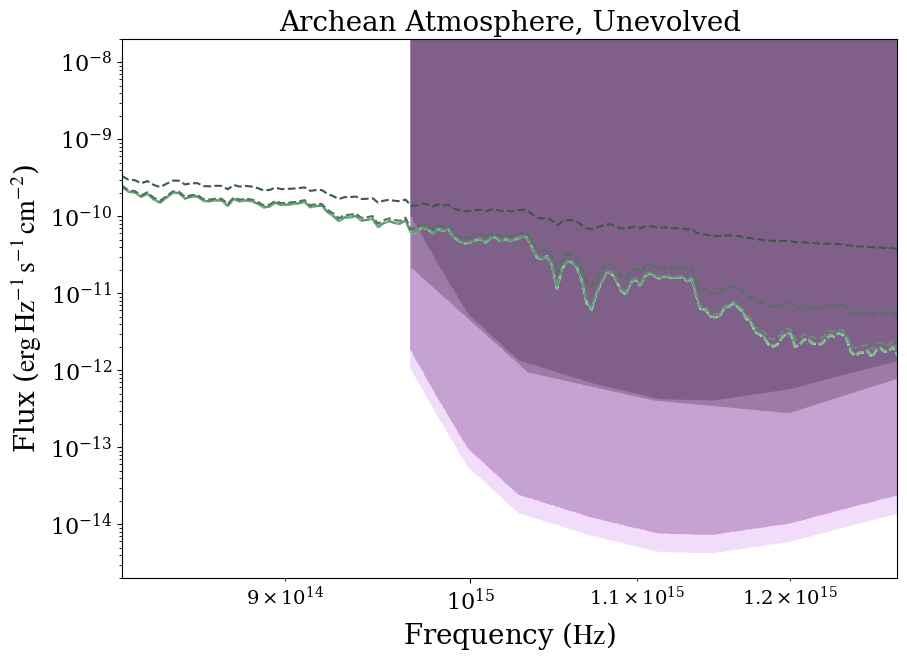

In [36]:
#panel 5/6 of Figure 4

colorlist=["#A2ECBC", "#8FD1A6", "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]

plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap, 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap, 2e-5, color="#7E6089", label="Danger to D. Radiodurans")

plt.loglog(freq, sun_surf_fnu_arch, linestyle="dashed", color="#AEFFCB", label="No AGN")

index=0
bolcorrs = 2.285226886530375*np.logspace(11,16,6) #bol corrs in question
for b in bolcorrs:
    plt.loglog(freq, (agn_fnufilt_arch*b)+sun_surf_fnu_arch, linestyle="dashed", color= colorlist[index], label="{}".format(clist[index]))
    index=index+1

yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-15,2e-8)

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)
plt.title("Archean Atmosphere, Unevolved",fontsize=20)
plt.tick_params(axis='both',labelsize=16)

# plt.legend(loc="lower left", fontsize=20)

# plt.savefig('/Users/sippy/Desktop/arch_unevolved_sbs_'+str(date.today())+'.png')

In [37]:
area_arch_unevolved = np.zeros((7,4))*u.erg*(u.s**(-1))*(u.cm**(-2))

bolcorrs = np.concatenate(([0],2.285226886530375*np.logspace(11,17,7))) #bol corrs in question
for i in range(0,7):
        area_arch_unevolved[i,0] = limitedintegrate((agn_fnufilt_arch*bolcorrs[i])+sun_surf_fnu_arch,freq,human_fnu,human_freq)
        area_arch_unevolved[i,2] = limitedintegrate((agn_fnufilt_arch*bolcorrs[i])+sun_surf_fnu_arch,freq,rat_fnu_extrap,rat_freq_extrap)
        area_arch_unevolved[i,1] = limitedintegrate((agn_fnufilt_arch*bolcorrs[i])+sun_surf_fnu_arch,freq,ecol_fnu_extrap,human_freq)
        area_arch_unevolved[i,3] = limitedintegrate((agn_fnufilt_arch*bolcorrs[i])+sun_surf_fnu_arch,freq,drad_fnu_extrap,human_freq)

print(area_arch_unevolved)

[[ 6067.55707217  6056.2135145   5360.90382759  4760.57614514]
 [ 6067.72985364  6056.38629597  5361.07431226  4760.74434348]
 [ 6069.28488688  6057.94132921  5362.60867434  4762.25812859]
 [ 6084.83521927  6073.4916616   5377.95229508  4777.39597968]
 [ 6240.33854311  6228.99498544  5531.38850256  4928.77449052]
 [ 7795.37178151  7784.02822384  7065.75057729  6442.55959895]
 [23345.70416554 23334.36060787 22409.37132457 21849.33837852]] erg / (s cm2)


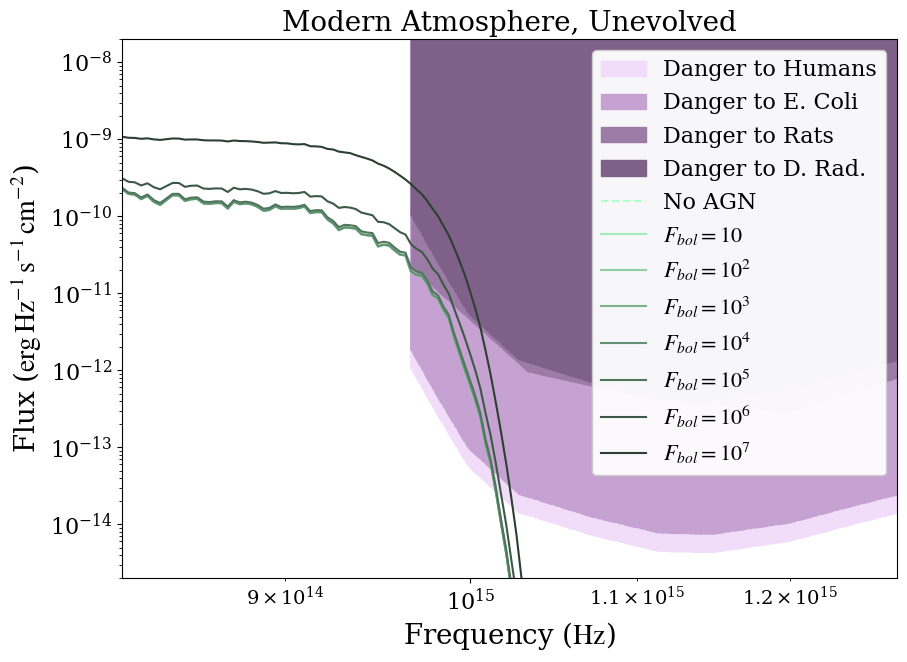

In [38]:
#panel 6/6 of Figure 4

colorlist=["#A2ECBC", "#8FD1A6", "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]

plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap, 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap, 2e-5, color="#7E6089", label="Danger to D. Rad.")

plt.loglog(freq, sun_surf_fnu_mod, linestyle="dashed", color="#AEFFCB", label="No AGN")

index=0
bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question
for b in bolcorrs:
    plt.loglog(freq, (agn_fnufilt_mod*b)+sun_surf_fnu_mod, linestyle="solid", color= colorlist[index], label="{}".format(clist[index])) 
    index=index+1

yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-15,2e-8)

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)
plt.title("Modern Atmosphere, Unevolved",fontsize=20)
plt.tick_params(axis='both',labelsize=16)


plt.legend(loc="upper right", framealpha=0.95, fontsize=16)

# plt.savefig('/Users/sippy/Desktop/mod_unevolved_sbs_'+str(date.today())+'.png')

In [39]:
area_mod_unevolved = np.zeros((8,4))*u.erg*(u.s**(-1))*(u.cm**(-2))

bolcorrs = np.concatenate(([0],2.285226886530375*np.logspace(11,17,7))) #bol corrs in question
for i in range(0,8):
        area_mod_unevolved[i,0] = limitedintegrate((agn_fnufilt_mod*bolcorrs[i])+sun_surf_fnu_mod,freq,human_fnu,human_freq)
        area_mod_unevolved[i,2] = limitedintegrate((agn_fnufilt_mod*bolcorrs[i])+sun_surf_fnu_mod,freq,rat_fnu_extrap,rat_freq_extrap)
        area_mod_unevolved[i,1] = limitedintegrate((agn_fnufilt_mod*bolcorrs[i])+sun_surf_fnu_mod,freq,ecol_fnu_extrap,human_freq)
        area_mod_unevolved[i,3] = limitedintegrate((agn_fnufilt_mod*bolcorrs[i])+sun_surf_fnu_mod,freq,drad_fnu_extrap,human_freq)

print(area_mod_unevolved)

[[2.93081727e+02 2.83328652e+02 0.00000000e+00 0.00000000e+00]
 [2.93085350e+02 2.83332275e+02 0.00000000e+00 0.00000000e+00]
 [2.93117954e+02 2.83364879e+02 0.00000000e+00 0.00000000e+00]
 [2.93443998e+02 2.83690923e+02 0.00000000e+00 0.00000000e+00]
 [2.96704436e+02 2.86951360e+02 3.73412138e-01 0.00000000e+00]
 [3.29318142e+02 3.19555734e+02 5.58348376e+00 0.00000000e+00]
 [6.55462065e+02 6.45645172e+02 2.10281744e+02 0.00000000e+00]
 [3.91739125e+03 3.90747007e+03 2.76276817e+03 2.64173922e+03]] erg / (s cm2)


# AGN only before and afters

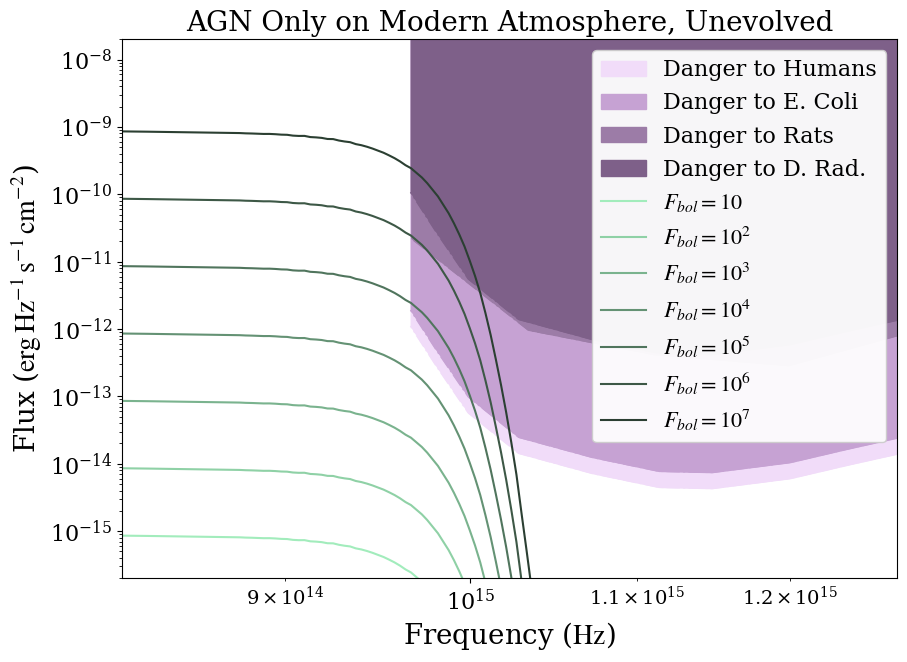

In [40]:
#panel 1/6 of Figure 6

colorlist=["#2B3F32", "#3D5846", "#50755D", "#649274", "#7AB38E", "#8FD1A6", "#A2ECBC"]
clist=["$F_{bol} = 10^7$", "$F_{bol} = 10^6$","$F_{bol} = 10^5$", "$F_{bol} = 10^4$","$F_{bol} = 10^3$", "$F_{bol} = 10^2$", "$F_{bol} = 10$"]



plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap, 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap, 2e-5, color="#7E6089", label="Danger to D. Rad.")

index=6
bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only
for b in bolcorrs:
    plt.loglog(freq, agn_fnufilt_mod*b, linestyle="solid", color= colorlist[index], label=clist[index]) 
    index=index-1


yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')


plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-16,2e-8)

plt.xlabel("Frequency ({})".format(xunit_string), fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string), fontsize=20)
plt.title("AGN Only on Modern Atmosphere, Unevolved", fontsize=20)
plt.tick_params(axis='both', labelsize=16)

plt.legend(loc="upper right", framealpha=0.95, fontsize=16)

# plt.savefig('/Users/sippy/Desktop/agnonly_mod_unevolved_'+str(date.today())+'.png')

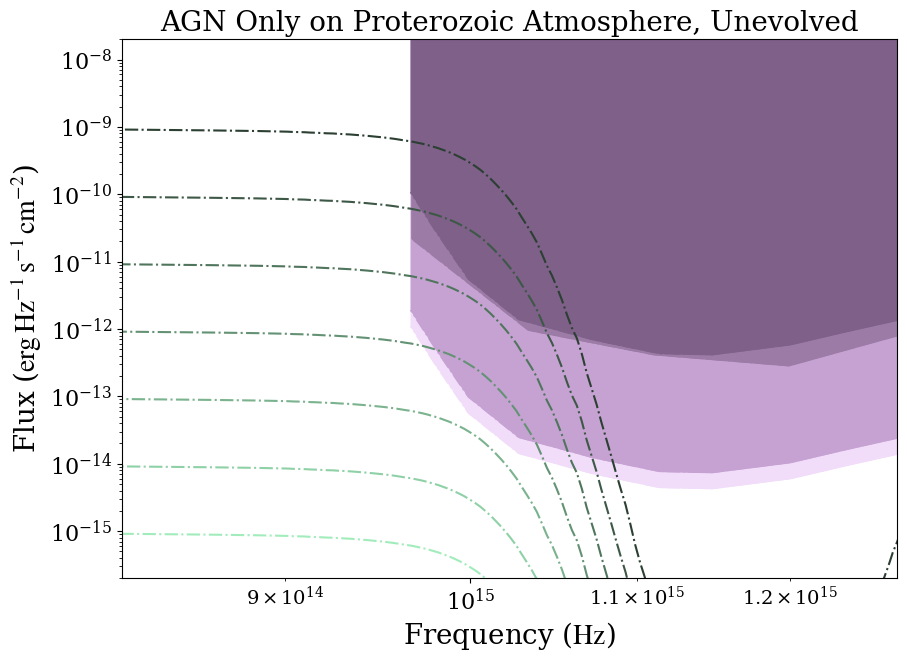

In [41]:
#panel 2/6 of Figure 6

colorlist=["#2B3F32", "#3D5846", "#50755D", "#649274", "#7AB38E", "#8FD1A6", "#A2ECBC"]
clist=["$F_{bol} = 10^7$", "$F_{bol} = 10^6$","$F_{bol} = 10^5$", "$F_{bol} = 10^4$","$F_{bol} = 10^3$", "$F_{bol} = 100$", "$F_{bol} = 10$"]



plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap, 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap, 2e-5, color="#7E6089", label="Danger to D. Radiodurans")

index=6
bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only
for b in bolcorrs:
    plt.loglog(freq, agn_fnufilt_prot*b, linestyle="dashdot", color= colorlist[index])
    index=index-1


yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')


plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-16,2e-8)

plt.xlabel("Frequency ({})".format(xunit_string), fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string), fontsize=20)
plt.title("AGN Only on Proterozoic Atmosphere, Unevolved", fontsize=20)
plt.tick_params(axis='both', labelsize=16)

# plt.legend(loc="upper right", framealpha=0.95, fontsize=16)

# plt.savefig('/Users/sippy/Desktop/agnonly_prot_unevolved_'+str(date.today())+'.png')

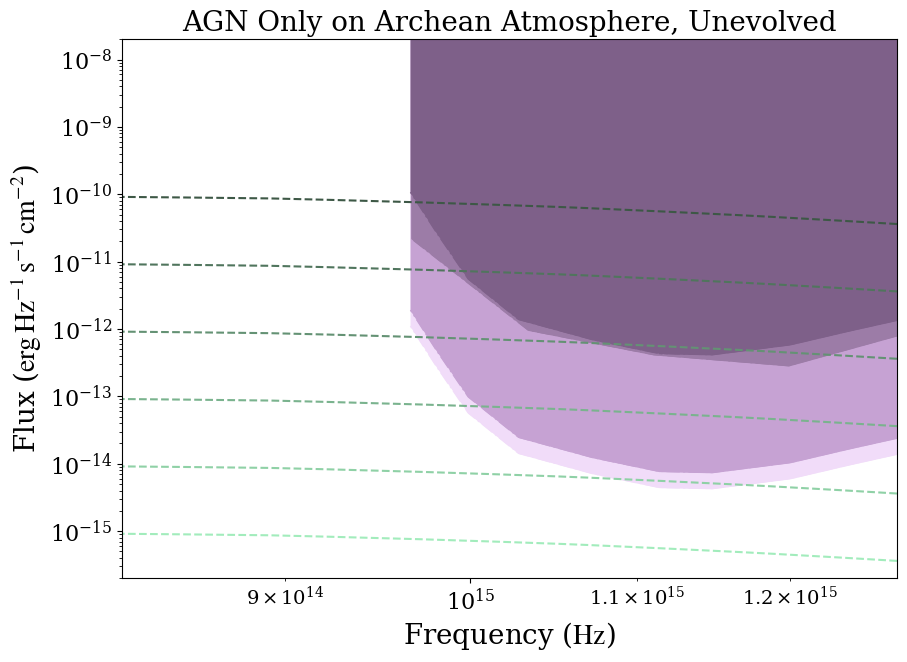

In [42]:
#panel 3/6 of Figure 6

colorlist=["#2B3F32", "#3D5846", "#50755D", "#649274", "#7AB38E", "#8FD1A6", "#A2ECBC"]
clist=["$F_{bol} = 10^7$", "$F_{bol} = 10^6$","$F_{bol} = 10^5$", "$F_{bol} = 10^4$","$F_{bol} = 10^3$", "$F_{bol} = 100$", "$F_{bol} = 10$"]


plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap, 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap, 2e-5, color="#7E6089", label="Danger to D. Radiodurans")

index=6
bolcorrs = 2.285226886530375*np.logspace(11,16,6) #bol corrs in question #do np.logspace(11,17,4) for odds only
for b in bolcorrs:
    plt.loglog(freq, agn_fnufilt_arch*b, linestyle="dashed", color= colorlist[index])
    index=index-1


yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-16,2e-8)

plt.xlabel("Frequency ({})".format(xunit_string), fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string), fontsize=20)
plt.title("AGN Only on Archean Atmosphere, Unevolved", fontsize=20)
plt.tick_params(axis='both', labelsize=16)

# plt.legend(loc="upper right", framealpha=0.95, fontsize=16)

# plt.savefig('/Users/sippy/Desktop/agnonly_arch_unevolved_'+str(date.today())+'.png')

In [52]:
#these are to make 'after' plots with AGN flux only


f = sc.interp1d(agn_freq, agn_fnu, bounds_error=False) #starting w just the AGN
agn_fnufilt_prot_all = np.zeros((750,8)) #all the filters
for n in range(0,750):
    match = f(freq[n]) #find sed flux corr. to the freq 
    agn_fnufilt_prot_all[n,:] = match*prot_trans_all[n,:] #multiply the relevant correction (which we read across prot_trans_all, corr.
        #to various frequencies) and apply to the agn SED flux at said frequency.
agn_fnufilt_prot_all = agn_fnufilt_prot_all*agn_fnu.unit
# print(agn_fnufilt_prot_all)

f = sc.interp1d(agn_freq, agn_fnu, bounds_error=False) #starting w just the AGN
agn_fnufilt_arch_all = np.zeros((750,7)) #all the filters
for n in range(0,750):
    match = f(freq[n]) #find sed flux corr. to the freq 
#     print(nitsch[c,0],match, nitsch[c,1])
    agn_fnufilt_arch_all[n,:] = match*arch_trans_all[n,:] #multiply the relevant correction (which we read across prot_trans_all, corr.
        #to various frequencies) and apply to the agn SED flux at said frequency.
# print(agn_fnufilt)
agn_fnufilt_arch_all = agn_fnufilt_arch_all*agn_fnu.unit
# print(agn_fnufilt_arch_all)

f = sc.interp1d(agn_freq, agn_fnu, bounds_error=False) #starting w just the AGN
agn_fnufilt_mod_all = np.zeros((750,8)) #all the filters
for n in range(0,750):
    match = f(freq[n]) #find sed flux corr. to the freq 
#     print(nitsch[c,0],match, nitsch[c,1])
    agn_fnufilt_mod_all[n,:] = match*mod_trans_all[n,:] #multiply the relevant correction (which we read across prot_trans_all, corr.
        #to various frequencies) and apply to the agn SED flux at said frequency.
# print(agn_fnufilt)
agn_fnufilt_mod_all = agn_fnufilt_mod_all*agn_fnu.unit
# print(agn_fnufilt_mod_all)

Text(0.5, 1.0, 'AGN Only on Modern Atmosphere, Evolved')

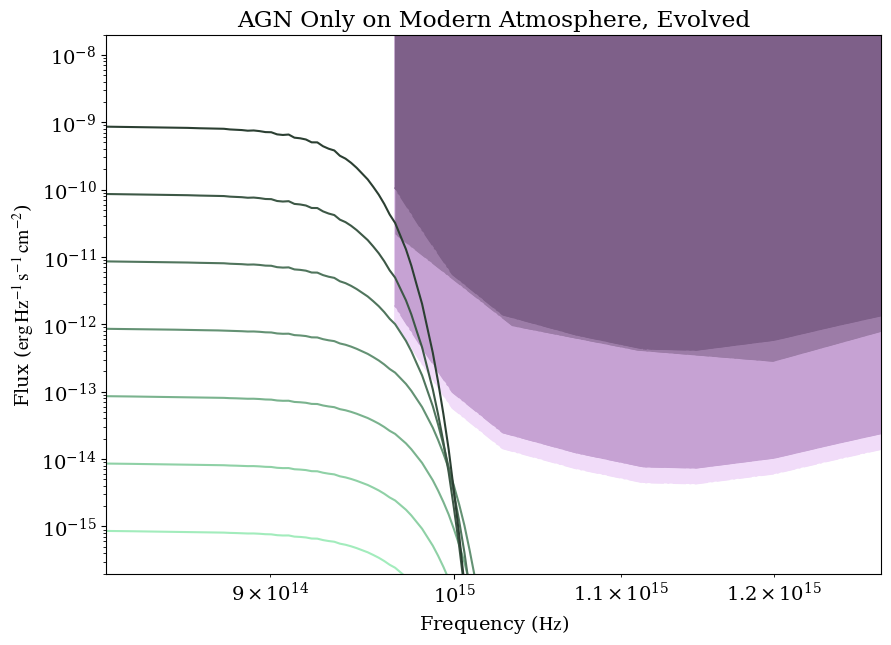

In [54]:
#panel 4/6 of Figure 6

colorlist=["#A2ECBC","#8FD1A6","#7AB38E","#649274","#50755D","#3D5846", "#2B3F32"]
clist=["$F_{bol} = 10$", "$F_{bol} = 10^2$","$F_{bol} = 10^3$", "$F_{bol} = 10^4$","$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]


plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap[:], 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap[:], 2e-5, color="#7E6089", label="Danger to D. Radiodurans")


bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only
for f in range(0,7):
    plt.loglog(freq, agn_fnufilt_mod_all[:,f+1]*bolcorrs[f], linestyle="solid", color= colorlist[f], label=clist[f]) 


yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlabel("Frequency ({})".format(xunit_string))
plt.ylabel("Flux ({})".format(yunit_string))

plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-16,2e-8)

plt.title("AGN Only on Modern Atmosphere, Evolved")

# plt.legend(loc="upper right", framealpha=0.95, fontsize=12)

# plt.savefig('/Users/sippy/Desktop/agnonly_mod_evolved_'+str(date.today())+'.png')

Text(0.5, 1.0, 'AGN Only on Proterozoic Atmosphere, Evolved')

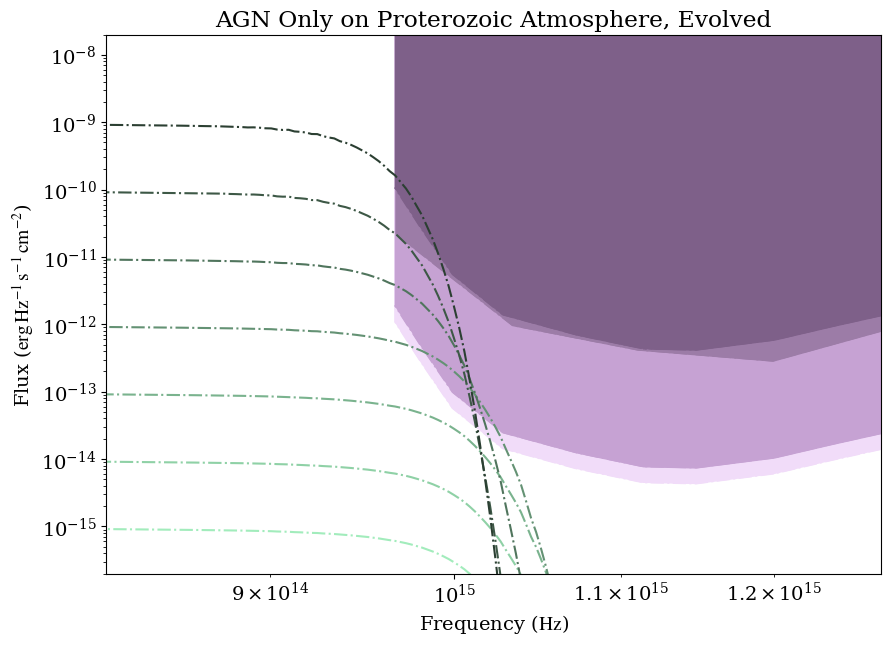

In [55]:
#panel 5/6 of Figure 6

colorlist=["#A2ECBC","#8FD1A6","#7AB38E","#649274","#50755D","#3D5846", "#2B3F32"]
clist=["$F_{bol} = 10$", "$F_{bol} = 10^2$","$F_{bol} = 10^3$", "$F_{bol} = 10^4$","$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]


plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap[:], 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap[:], 2e-5, color="#7E6089", label="Danger to D. Radiodurans")

# index=6
bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only
for f in range(0,7):
    plt.loglog(freq, agn_fnufilt_prot_all[:,f+1]*bolcorrs[f], linestyle="dashdot", color= colorlist[f], label=clist[f]) 


yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlabel("Frequency ({})".format(xunit_string))
plt.ylabel("Flux ({})".format(yunit_string))

plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-16,2e-8)

plt.title("AGN Only on Proterozoic Atmosphere, Evolved")

# plt.legend(loc="upper right", framealpha=0.95, fontsize=12)

# plt.savefig('/Users/sippy/Desktop/agnonly_prot_evolved_'+str(date.today())+'.png')

Text(0.5, 1.0, 'AGN Only on Archean Atmosphere, Evolved')

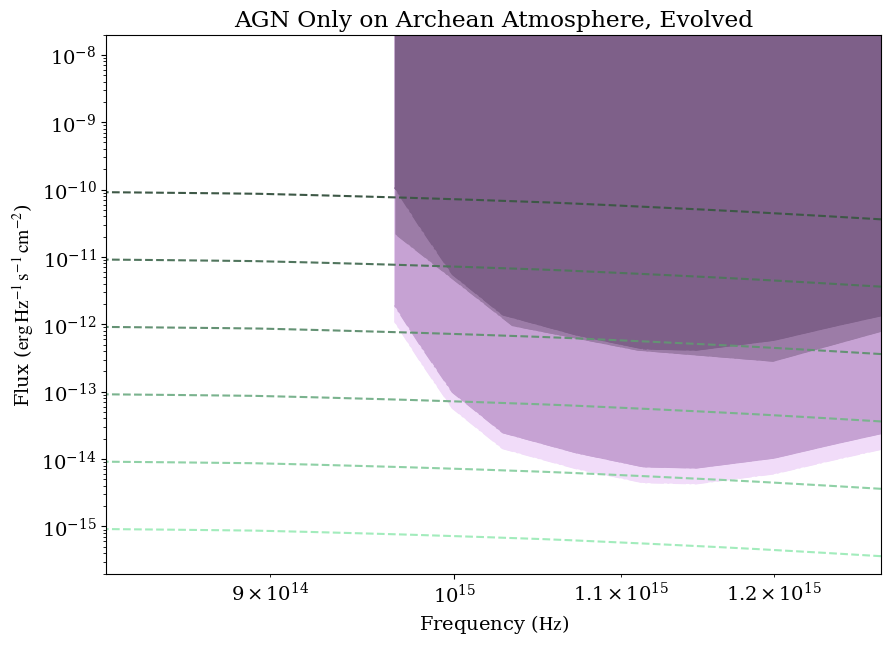

In [57]:
#panel 6/6 of Figure 6

colorlist=["#A2ECBC","#8FD1A6","#7AB38E","#649274","#50755D","#3D5846", "#2B3F32"]
clist=["$F_{bol} = 10$", "$F_{bol} = 10^2$","$F_{bol} = 10^3$", "$F_{bol} = 10^4$","$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]


plt.loglog(human_freq, human_fnu, linestyle="dashdot", color = "#F1DCF9")
plt.fill_between(human_freq.value, human_fnu.value, 2e-5, color="#F1DCF9", label = "Danger to Humans")

plt.loglog(human_freq, ecol_fnu_extrap, linestyle="dashdot", color="#C6A2D3")
plt.fill_between(human_freq.value, ecol_fnu_extrap[:], 2e-5, color="#C6A2D3", label="Danger to E. Coli")

plt.loglog(rat_freq_extrap, rat_fnu_extrap, linestyle= "dashdot", color="#9C7CA7")
plt.fill_between(rat_freq_extrap.value, rat_fnu_extrap.value, 2e-5, color = "#9C7CA7", label ="Danger to Rats")

plt.loglog(human_freq, drad_fnu_extrap, linestyle="dashdot", color="#7E6089")
plt.fill_between(human_freq.value, drad_fnu_extrap[:], 2e-5, color="#7E6089", label="Danger to D. Radiodurans")


bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only
for f in range(0,6):
    plt.loglog(freq, agn_fnufilt_arch_all[:,f+1]*bolcorrs[f], linestyle="dashed", color= colorlist[f], label=clist[f]) 



yunit_string = agn_fnu.unit.to_string('latex_inline')
xunit_string = agn_freq.unit.to_string('latex_inline')

plt.xlabel("Frequency ({})".format(xunit_string))
plt.ylabel("Flux ({})".format(yunit_string))

plt.xlim(8.2e+14, np.max(human_freq).value)
plt.ylim(2e-16,2e-8)

plt.title("AGN Only on Archean Atmosphere, Evolved")

# plt.legend(loc="upper right", framealpha=0.95, fontsize=12)

# plt.savefig('/Users/sippy/Desktop/agnonly_arch_evolved_'+str(date.today())+'.png')

# Incoming Flux

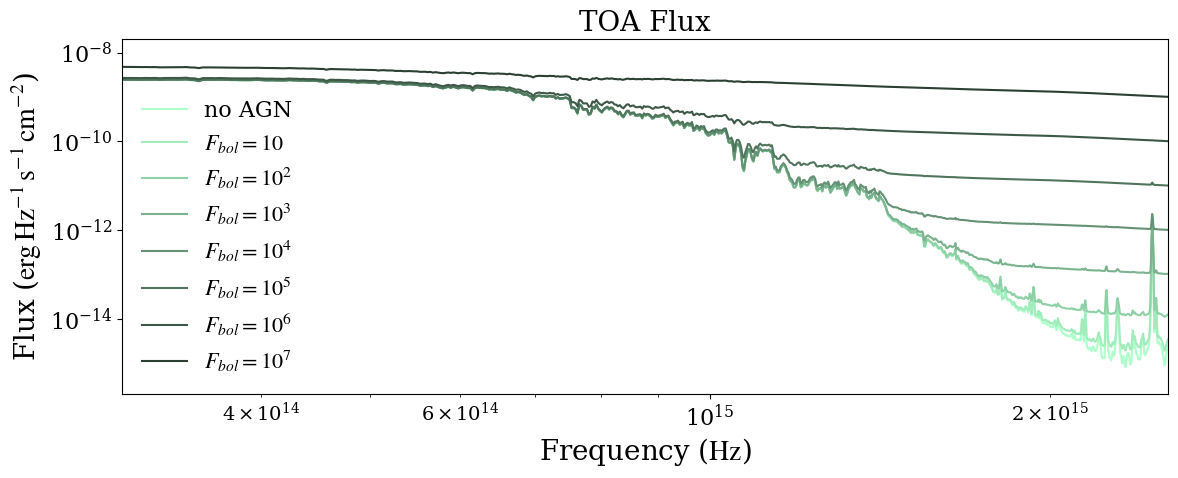

In [43]:
#panel 1/4 of Figure 1

colorlist=["#AEFFCB", "#A2ECBC", "#8FD1A6",  "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["no AGN", "$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]
o2_string = "$0.21$"

fig = plt.figure(figsize=(12,5))

for f in range(0,8):
    plt.loglog(freq, mod_fnu_TOA[:,f], color=colorlist[f], linestyle="solid", label = clist[f])


yunit_string = mod_fnu_TOA.unit.to_string('latex_inline')
xunit_string = freq.unit.to_string('latex_inline')

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)

plt.legend(loc='lower left', frameon=False,fontsize=16)
plt.ylim(2e-16,2e-8)
plt.xlim(freq[749].value, freq[0].value)
plt.title("TOA Flux",fontsize=20)
plt.tick_params(axis='both',labelsize=16)

plt.tight_layout()
plt.show()

# fig.savefig('/Users/sippy/Desktop/toa_flux_'+str(date.today())+'.png')

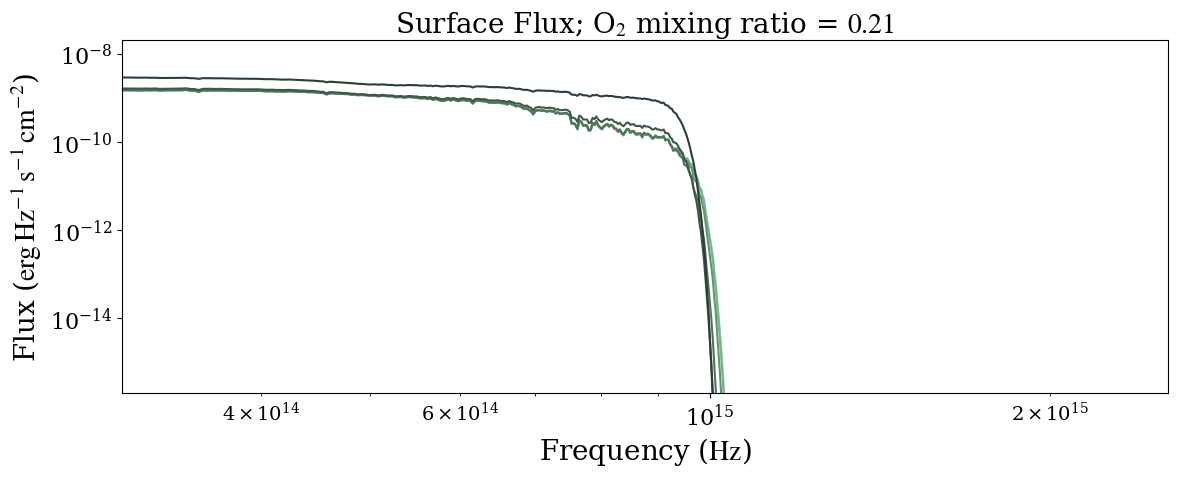

In [44]:
#panel 2/4 of Figure 1

colorlist=["#AEFFCB", "#A2ECBC", "#8FD1A6",  "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["no AGN", "$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]
o2_string = "$0.21$"

fig = plt.figure(figsize=(12,5))

for f in range(0,8):
    plt.loglog(freq, mod_fnu[:,f], color=colorlist[f], linestyle="solid", label = clist[f])


yunit_string = mod_fnu_TOA.unit.to_string('latex_inline')
xunit_string = freq.unit.to_string('latex_inline')

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)

# plt.legend(loc='lower left', frameon=False,fontsize=14)
plt.ylim(2e-16,2e-8)
plt.xlim(freq[749].value, freq[0].value)
plt.title("Surface Flux; O$_2$ mixing ratio = {}".format(o2_string),fontsize=20)
plt.tick_params(axis='both',labelsize=16)

plt.tight_layout()
plt.show()

# fig.savefig('/Users/sippy/Desktop/mod_flux_'+str(date.today())+'.png')

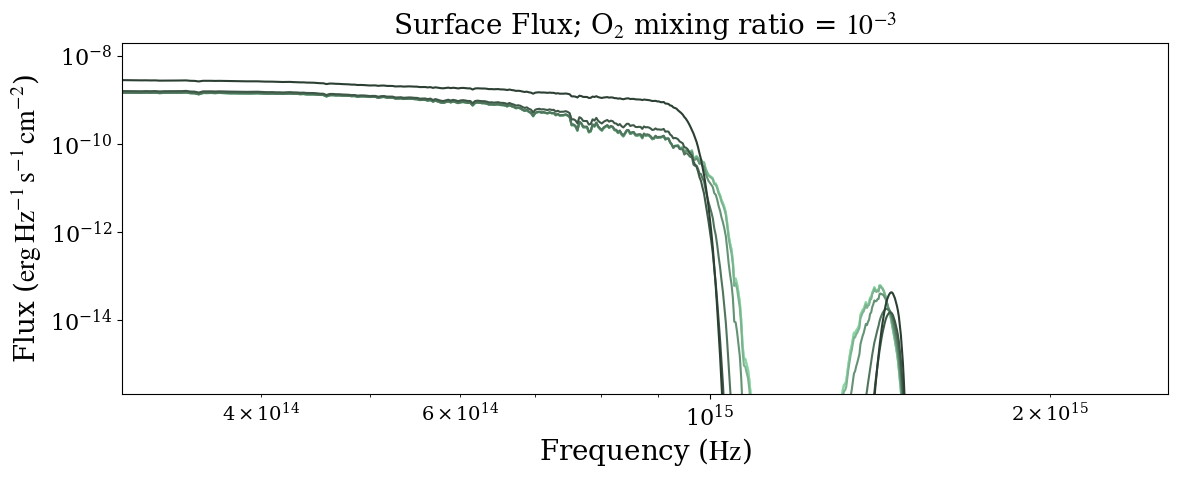

In [45]:
#panel 3/4 of Figure 1

colorlist=["#AEFFCB", "#A2ECBC", "#8FD1A6",  "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["no AGN", "$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]
o2_string = "$10^{-3}$"

fig =plt.figure(figsize=(12,5))

for f in range(0,8):
    plt.loglog(freq, prot_fnu[:,f], color=colorlist[f], linestyle="solid", label = clist[f])


yunit_string = mod_fnu_TOA.unit.to_string('latex_inline')
xunit_string = freq.unit.to_string('latex_inline')

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)

# plt.legend(loc='lower left', frameon=False,fontsize=14)
plt.ylim(2e-16,2e-8)
plt.xlim(freq[749].value, freq[0].value)
plt.title("Surface Flux; O$_2$ mixing ratio = {}".format(o2_string),fontsize=20)
plt.tick_params(axis='both',labelsize=16)

plt.tight_layout()
plt.show()

# fig.savefig('/Users/sippy/Desktop/prot_flux_'+str(date.today())'.png')

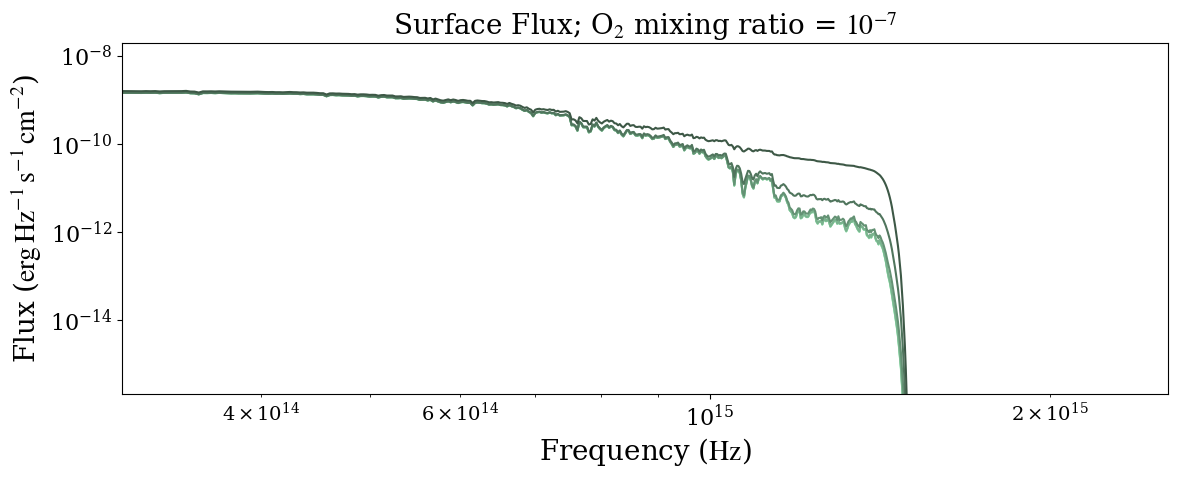

In [46]:
#panel 4/4 of Figure 1

colorlist=["#AEFFCB", "#A2ECBC", "#8FD1A6",  "#7AB38E", "#649274", "#50755D", "#3D5846", "#2B3F32"]
clist=["no AGN", "$F_{bol} = 10$","$F_{bol} = 10^2$", "$F_{bol} = 10^3$", "$F_{bol} = 10^4$", "$F_{bol} = 10^5$", "$F_{bol} = 10^6$", "$F_{bol} = 10^7$"]
o2_string = "$10^{-7}$"

fig=plt.figure(figsize=(12,5))

for f in range(0,7):
    plt.loglog(freq, arch_fnu[:,f], color=colorlist[f], linestyle="solid", label = clist[f])


yunit_string = mod_fnu_TOA.unit.to_string('latex_inline')
xunit_string = freq.unit.to_string('latex_inline')

plt.xlabel("Frequency ({})".format(xunit_string),fontsize=20)
plt.ylabel("Flux ({})".format(yunit_string),fontsize=20)

# plt.legend(loc='lower left', frameon=False,fontsize=14)
plt.ylim(2e-16,2e-8)
plt.xlim(freq[749].value, freq[0].value)
plt.title("Surface Flux; O$_2$ mixing ratio = {}".format(o2_string),fontsize=20)
plt.tick_params(axis='both',labelsize=16)

plt.tight_layout()
plt.show()

# fig.savefig('/Users/sippy/Desktop/arch_flux_'+str(date.today())+'.png')

# Incident Flux on surface vs. AGN flux total (Fig 5)

Text(10, 150.0, 'Modern, With Atm. Evolution')

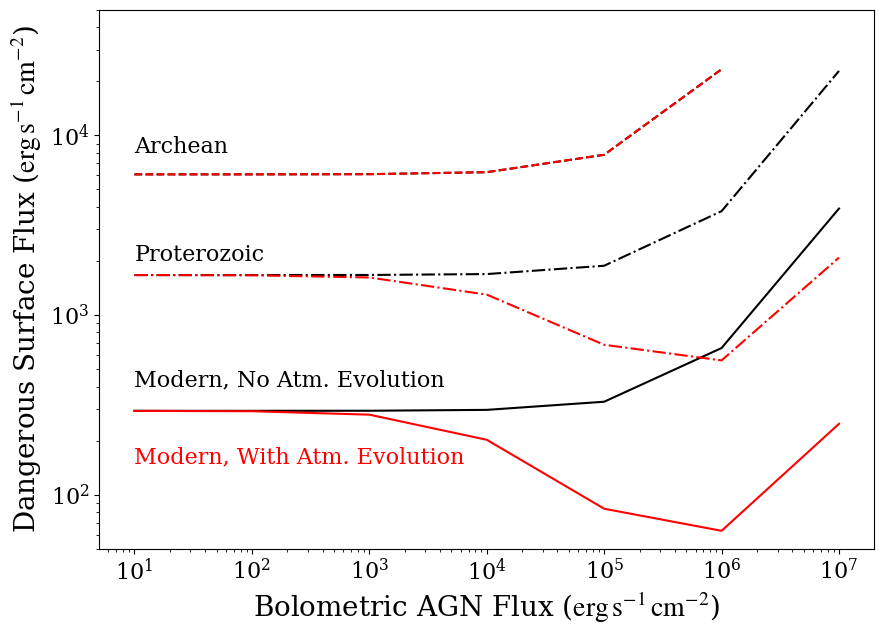

In [58]:
#Figure 5

bols = np.logspace(1,7,7)

plt.loglog(bols,area_mod_unevolved[1:,0],linestyle="solid",color="black", label="Modern, No Atm. Evolution") #values for all of these were generated as I made before and after plots
plt.loglog(bols,area_prot_unevolved[1:,0], linestyle="dashdot",color="black", label="Proterozoic")
plt.loglog(bols[:6],area_arch_unevolved[1:,0],linestyle="dashed", color="black", label="Archean")

plt.loglog(bols,area_mod_evolved[1:,0],linestyle="solid", color="red", label="Modern, With Atm. Evolution")
plt.loglog(bols,area_prot_evolved[1:,0], linestyle="dashdot", color="red", label="Proterozoic")
plt.loglog(bols[:6],area_arch_evolved[1:,0], linestyle="dashed", color="red", label="Archean")


xunit_string = area_mod_evolved.unit.to_string('latex_inline')

plt.xlabel("Bolometric AGN Flux ({})".format(xunit_string),fontsize=20)
plt.ylabel("Dangerous Surface Flux ({})".format(xunit_string),fontsize=20)
plt.tick_params(axis='both',labelsize=16)

plt.ylim(5e+1,5e+4)

# plt.legend(loc="upper left")
plt.annotate("Archean",(10,8e+3),fontsize=16)
plt.annotate("Proterozoic",(10,2e+3),fontsize=16)
plt.annotate("Modern, No Atm. Evolution", (10,4e+2),fontsize=16)
plt.annotate("Modern, With Atm. Evolution", (10,1.5e+2),color="red",fontsize=16)


# plt.savefig("/Users/sippy/Desktop/moneyplot'+str(date.today())+'.png")

# Percentages of stars (therefore planets) above radiation limits *BEFORE* atm. evolution (Tables)

In [83]:
agn_sed = np.loadtxt("/Users/sippy/Thesis/quasar SED.csv", delimiter =",")
#mean quasar SED from Richards et al. 2006 fig 9, [:,0] is log(frequency) in log(Hz), [:,1] is F_\nu microJy

agn_freq = agn_sed[:,0]*u.dex(u.Hz)
agn_fnu = agn_sed[:,1]*u.uJy

agn_freq = agn_freq.to(u.Hz)
agn_fnu = agn_fnu.to(u.erg*(u.cm**(-2))*(u.s**(-1))*(u.Hz**(-1)))


In [129]:
#just a different way of getting the AGN only flux (which I was using when I wrote this code and don't want to go through changing now)

protero_TOA = np.loadtxt("/Users/sippy/Thesis/Evolved_Protero_TOA.csv", delimiter=",")
protero_surf = np.loadtxt("/Users/sippy/Thesis/Evolved_Protero_Surf.csv", delimiter=",")
    #[:,0] are wavelength in nm, rest are F_nu in mW/m^2/A

prot_flambda = protero_surf[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
prot_TOA_flambda = protero_TOA[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
#i'll just ratio the flambda since it's all the same thing

prot_trans = prot_flambda[:,0]/prot_TOA_flambda[:,0] #the [:,0] are the no agn case

sun_surf_fnu_prot = prot_fnu[:,0]

arch_TOA = np.loadtxt("/Users/sippy/Thesis/Evolved_Arch_TOA.csv", delimiter=",")
arch_surf = np.loadtxt("/Users/sippy/Thesis/Evolved_Arch_Surf.csv", delimiter=",")
    #[:,0] are wavelength in nm, rest are F_nu in mW/m^2/A

arch_flambda = arch_surf[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
arch_TOA_flambda = arch_TOA[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
#i'll just ratio the flambda since it's all the same thing

arch_trans = arch_flambda[:,0]/arch_TOA_flambda[:,0] #the [:,0] are the no agn case

sun_surf_fnu_arch = arch_fnu[:,0]

mod_TOA = np.loadtxt("/Users/sippy/Thesis/Evolved_Mod_TOA.csv", delimiter=",")
mod_surf = np.loadtxt("/Users/sippy/Thesis/Evolved_Mod_Surf.csv", delimiter=",")
    #[:,0] are wavelength in nm, rest are F_nu in mW/m^2/A

mod_flambda = mod_surf[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
mod_TOA_flambda = mod_TOA[:,1:]*u.mW*(u.m**(-2))*(u.Angstrom**(-1))
#i'll just ratio the flambda since it's all the same thing

mod_trans = mod_flambda[:,0]/mod_TOA_flambda[:,0] #the [:,0] are the no agn case

sun_surf_fnu_mod = mod_fnu[:,0]

f = sc.interp1d(agn_freq, agn_fnu, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
agn_fnufilt_prot = np.zeros(np.shape(prot_trans))
for n in range(0,np.shape(prot_trans)[0]):
    match = f(freq[n]) #find sed flux corr. to the freq 
    agn_fnufilt_prot[n] = match*prot_trans[n]
agn_fnufilt_prot = agn_fnufilt_prot*agn_fnu.unit

f = sc.interp1d(agn_freq, agn_fnu, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
agn_fnufilt_arch = np.zeros(np.shape(arch_trans))
for n in range(0,np.shape(arch_trans)[0]):
    match = f(freq[n]) #find sed flux corr. to the freq 
    agn_fnufilt_arch[n] = match*arch_trans[n]
agn_fnufilt_arch = agn_fnufilt_arch*agn_fnu.unit

f = sc.interp1d(agn_freq, agn_fnu, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
agn_fnufilt_mod = np.zeros(np.shape(mod_trans))
for n in range(0,np.shape(mod_trans)[0]):
    match = f(freq[n]) #find sed flux corr. to the freq 
    agn_fnufilt_mod[n] = match*mod_trans[n]
agn_fnufilt_mod = agn_fnufilt_mod*agn_fnu.unit



In [87]:
#this pipeline can be run for one galaxy at a time--- run this code box and then run all the rest in this section after

gal_name = input("Galaxy Name")
gal_name = str(gal_name)
path = "/Users/sippy/Thesis/"
file_name = input("Stellar pop filename")
file_name = str(path+file_name)

if gal_name=="M87": #m87pop_rad.csv
    galaxy = np.loadtxt("{}".format(file_name), delimiter=",") #from Gebhardt & Thomas (2009), Figure 1
    galaxy_radii = galaxy[:,0]*u.arcsec
    galaxy_popdens = galaxy[:,1]*u.L_sun*(u.pc**(-3))
    
    galaxy_radii = galaxy_radii.to(u.radian)
    galaxy_radii = galaxy_radii*16.4e+6*u.pc/u.radian #not really 'dividing' by radians, but just to make units work out

    galaxy_pop = np.zeros((np.shape(galaxy_popdens)[0]-1))*u.L_sun
    for d in range(0,np.shape(galaxy_popdens)[0]-1):
        integrand = galaxy_popdens*4*np.pi*(galaxy_radii[:]**2) 
        
        integral = np.trapz(integrand[0:d+2], galaxy_radii[0:d+2])
        integral = integral.to(u.L_sun)
        
        galaxy_pop[d] = integral
    
elif gal_name=="Milky Way Bulge": #MW Bulge Pop.csv
    galaxy = np.loadtxt("{}".format(file_name), delimiter=",") #from Sofue et al. (2009) Fig 3
    galaxy_radii = galaxy[:,0]*u.kpc
    galaxy_pop = galaxy[:,1]*1e+11*u.M_sun #assuming 1 star = 1 M_sun
    
    galaxy_radii = galaxy_radii.to(u.pc)

    #note that I extrapolated this one by having 0 stars contained at 0 radii, the next nearest point is around 167 pc... but it looks 
    #pretty similar to what a power law would have done, based on inspection.
    
else: #i.e. red nugget relics

    galaxy = np.loadtxt("{}".format(file_name), delimiter=",") #all from Yildirim et al. (2017) Figure 6
    galaxy_radii = galaxy[:,0]*u.kpc #this is R, projected radius
    galaxy_dist = galaxy[:,1]*u.dex(u.M_sun/(u.kpc**2)) #this is I(R), brightness per projected area
        
    galaxy_radii = galaxy_radii.to(u.pc)
    galaxy_dist = galaxy_dist.to(u.M_sun/(u.kpc**2))
    
    extrap_radii = np.logspace(1,np.log10((np.min(galaxy_radii.value) - 0.01)),20) #in pc, setting the upper value equal to the lowest existing radii value
    
    def y(x,a,b):
        y = a*(x**b)
        return y #power law
    
    sample_indices = np.where(300*u.pc>= galaxy_radii[:]) #the 300 is arbitrary
    sample_radii = galaxy_radii[sample_indices]
    sample_dist = galaxy_dist[sample_indices]
    #sample of the first however many datapoints
    
    popt1, pcov1 = curve_fit(y, sample_radii, sample_dist, p0=[1,1])
    
    extrap_dist = y(extrap_radii, popt1[0],popt1[1])*u.M_sun/(u.kpc**2)

    galaxy_dist = np.concatenate((extrap_dist, galaxy_dist))
    extrap_radii = extrap_radii*u.pc
    galaxy_radii = np.concatenate((extrap_radii, galaxy_radii)) #units of pc
    
    galaxy_radii = galaxy_radii.to(u.dex(u.pc))
    galaxy_dist = galaxy_dist.to(u.dex(u.M_sun/(u.kpc**2)))
    
    galaxy_radii_project = np.logspace(1,4.3065,70) #covering the range that all the galaxy_radii go through, this is in pc
    f = interp1d(galaxy_radii, galaxy_dist, bounds_error=False) #match a radius onto the (projected) surface brightness
    #note that these are both in dex so we are interpolating in log space
    galaxy_dist_interp = f(np.log10(galaxy_radii_project))*u.dex(u.M_sun/(u.kpc**2))
    # galaxy_dist_interp = galaxy_dist_interp.to(u.M_sun/(u.kpc**2))
    galaxy_radii_project = galaxy_radii_project*u.pc #now add units, so as not the mess up interpolation before
    #doing the interpolation also fixes the issues we had with gaps in the data due to that crazy plot.

    nan_indices = np.argwhere(np.isnan(galaxy_dist_interp))
    galaxy_dist_interp = np.delete(galaxy_dist_interp, nan_indices) #ok this works
    galaxy_radii_project = np.delete(galaxy_radii_project, nan_indices)
    
    galaxy_radii_project = galaxy_radii_project.to(u.pc)
    galaxy_dist_interp = galaxy_dist_interp.to(u.M_sun/(u.kpc**2))
    
    dIdR = -1*diff(galaxy_dist_interp)/diff(galaxy_radii_project) #use this to numerically differentiate
    dIdR = dIdR.decompose()

    galaxy_popdens = np.zeros((np.shape(dIdR)[0]-1))*u.M_sun/(u.pc**3) #fill these in w population density values
    for r in range(0,np.shape(dIdR)[0]-1):
        r_radius = galaxy_radii_project[r].to(u.pc)
        
        if r_radius >= np.max(galaxy_radii_project): #max of array elements
            galaxy_popdens[r] = 0*u.M_sun/(u.pc**3)
            continue #because if r > R in the equation then it becomes imaginary & integral doesn't work
        else:
                
            integrand = dIdR/np.sqrt((galaxy_radii_project[1:]**2) - (r_radius**2))
            integrand = integrand.decompose()
    
            integral = np.trapz(integrand[r:], galaxy_radii_project[1+r:])
            integral = integral.to(u.M_sun/(u.pc**3))
                
            galaxy_popdens[r] = integral

    #now having this, we still need to convert to population as a function of radius, rather than a density

    galaxy_pop = np.zeros((np.shape(galaxy_popdens)[0]-1))*u.M_sun
    for d in range(0,np.shape(galaxy_popdens)[0]-1):
        integrand = galaxy_popdens*4*np.pi*(galaxy_radii_project[2:]**2) 
        
        integral = np.trapz(integrand[0:d+2], galaxy_radii_project[2:d+2+2])
        integral = integral.to(u.M_sun)
        
        galaxy_pop[d] = integral

galaxy_pop_tot = np.max(galaxy_pop)
galaxy_popfrac = galaxy_pop/galaxy_pop_tot #M87 is in L_sun, rest are in M_sun, but this takes care of that

#these are general for all galaxies
mbh = input("Black hole mass, units of $10^6 M_\odot$") 
mbh = float(mbh)
mbh = mbh*1e+6*u.M_sun

Ledd = (4*np.pi*(c.G)*(c.m_p)*(c.c)/(c.sigma_T)) *(mbh)
Ledd = Ledd.to(u.erg/u.s)
print(Ledd)

def Flux(r): #radius goes in pc
    r = r.to(u.pc)
    Flux= (Ledd/(4*np.pi*(r**2)))
    Flux = Flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    return Flux
def bolcorr(r): #radius goes in pc
    r = r.to(u.pc)
    Flux= (Ledd/(4*np.pi*(r**2))) #this is total flux at dist r, in pc (turning pc to cm)
    corr= Flux/np.trapz(agn_fnu, agn_freq) #this gives us a correction from total flux of the mean quasar SED to the desired
#total flux, found above. This is 100% Edd, then just multiply this by 10% and 1% to get the others
    corr = corr.decompose()
    return corr 


6.159619381249274e+47 erg / s


In [88]:
#contents of t=0 rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 1/4

print(gal_name)

print("Modern")
f = sc.interp1d(freq, agn_fnufilt_mod, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 1*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,10):
        if human_freq[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(human_freq[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(human_fnu[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to humans at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))



#prot
print("Proterozoic")
f = sc.interp1d(freq, agn_fnufilt_prot, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 1*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,10):
        if human_freq[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(human_freq[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(human_fnu[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to humans at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))


#and archean
print("Archean")
f = sc.interp1d(freq, agn_fnufilt_arch, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 1*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,10):
        if human_freq[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(human_freq[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(human_fnu[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to humans at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))

NGC 1277
Modern
Danger to humans at 608.819242808272 pc ( 21.99974905281915 % of stellar population), at 100.0 % Eddington.
Flux = 4.142666181103888
Danger to humans at 192.4837150492082 pc ( 5.77711941006781 % of stellar population), at 10.0 % Eddington.
Flux = 4.142854937919707
Danger to humans at 60.70687637575781 pc ( 1.3240202656353026 % of stellar population), at 1.0 % Eddington.
Flux = 4.145167148013752
Proterozoic
Danger to humans at 2193.013232476564 pc ( 58.79778077364281 % of stellar population), at 100.0 % Eddington.
Flux = 3.029560417981035
Danger to humans at 687.7251317105386 pc ( 25.03101984816197 % of stellar population), at 10.0 % Eddington.
Flux = 3.036813132025679
Danger to humans at 215.32117917825755 pc ( 6.690995833370446 % of stellar population), at 1.0 % Eddington.
Flux = 3.0454694233381288
Archean
Danger to humans at 9264.35835623137 pc ( 99.8843894339483 % of stellar population), at 100.0 % Eddington.
Flux = 1.7780122308973065
Danger to humans at 2913.2905075

In [89]:
# actually need to add one more intermediatary datapoint onto the rat flux curve to make it find the right limits--- does not affect shape

f1 = interp1d(np.log10(rat_freq_extrap.value),np.log10(rat_fnu_extrap.value))

# print(rat_freq_extrap, rat_fnu_extrap)

lognewfreq=(np.log10(rat_freq_extrap[4].value)+np.log10(rat_freq_extrap[3].value))/2
lognewfnu = f1(lognewfreq)

newfreq = (10**lognewfreq)
newfnu = 10**(lognewfnu)


newfreq = np.array((newfreq))*u.Hz
newfnu = np.array((newfnu))*u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1))
newfreq = np.reshape(newfreq, (1))
newfnu = np.reshape(newfnu, (1))

rat_freq_extrap_extrap = np.concatenate((rat_freq_extrap[:4],newfreq))
# print(rat_freq_extrap_extrap)
append = np.array((rat_freq_extrap[4].value))*u.Hz
append = np.reshape(append, (1))
rat_freq_extrap_extrap = np.concatenate((rat_freq_extrap_extrap, append))
# print(rat_freq_extrap_extrap)

rat_fnu_extrap_extrap = np.concatenate((rat_fnu_extrap[:4],newfnu))
# print(rat_fnu_extrap_extrap)
appendf = np.array((rat_fnu_extrap[4].value))*u.erg*(u.s**(-1))*(u.cm**(-2))*(u.Hz**(-1))
appendf = np.reshape(appendf, (1))
rat_fnu_extrap_extrap = np.concatenate((rat_fnu_extrap_extrap, appendf))
# print(rat_fnu_extrap_extrap)

# plt.loglog(rat_freq_extrap_extrap, rat_fnu_extrap_extrap)

In [90]:
#contents of t=0 rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 2/4

# #rats

print(gal_name)

print("Modern")
f = sc.interp1d(freq, agn_fnufilt_mod, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,6):
        if rat_freq_extrap_extrap[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(rat_freq_extrap_extrap[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(rat_fnu_extrap_extrap[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to rats at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))



#prot
print("Proterozoic")
f = sc.interp1d(freq, agn_fnufilt_prot, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 0.001*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,6):
        if rat_freq_extrap_extrap[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(rat_freq_extrap_extrap[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(rat_fnu_extrap_extrap[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to rats at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))


#and archean
print("Archean")
f = sc.interp1d(freq, agn_fnufilt_arch, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 0.001*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,6):
        if rat_freq_extrap_extrap[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(rat_freq_extrap_extrap[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(rat_fnu_extrap_extrap[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to rats at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))


NGC 1277
Modern
Danger to rats at 104.27542045266274 pc ( 2.667920383497894 % of stellar population), at 100.0 % Eddington.
Flux = 5.6752790230407255
Danger to rats at 32.94891115348798 pc ( 0.5326633136412444 % of stellar population), at 10.0 % Eddington.
Flux = 5.675960787851527
Danger to rats at 10.386402850686364 pc ( nan % of stellar population), at 1.0 % Eddington.
Flux = 5.678712595782723
Proterozoic
Danger to rats at 242.92052576332577 pc ( 7.811208720104265 % of stellar population), at 100.0 % Eddington.
Flux = 4.940714497524757
Danger to rats at 77.02058669952216 pc ( 1.8145081677494619 % of stellar population), at 10.0 % Eddington.
Flux = 4.938429277331279
Danger to rats at 24.352869597705563 pc ( 0.3019436109093277 % of stellar population), at 1.0 % Eddington.
Flux = 4.938542635848833
Archean
Danger to rats at 1014.8965439398339 pc ( 35.79246581003985 % of stellar population), at 100.0 % Eddington.
Flux = 3.698799375166127
Danger to rats at 323.1103197266356 pc ( 11.0447364

In [91]:
#contents of t=0 rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 3/4

#e coli

print("Modern")
f = sc.interp1d(freq, agn_fnufilt_mod, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 1*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,10):
        if human_freq[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(human_freq[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(ecol_fnu_extrap[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to E. Coli at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))



#prot
print("Proterozoic")
f = sc.interp1d(freq, agn_fnufilt_prot, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 1*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,10):
        if human_freq[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(human_freq[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(ecol_fnu_extrap[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to E. Coli at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))


#and archean
print("Archean")
f = sc.interp1d(freq, agn_fnufilt_arch, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 1*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,10):
        if human_freq[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(human_freq[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(ecol_fnu_extrap[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to E. Coli at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))


Modern
Danger to E. Coli at 463.09956515653084 pc ( 16.442967220429736 % of stellar population), at 100.0 % Eddington.
Flux = 4.3802941759559335
Danger to E. Coli at 146.14829452236947 pc ( 4.055775261897005 % of stellar population), at 10.0 % Eddington.
Flux = 4.38205541890574
Danger to E. Coli at 46.018849434395804 pc ( 0.8975369149594339 % of stellar population), at 1.0 % Eddington.
Flux = 4.385771409920777
Proterozoic
Danger to E. Coli at 1658.111158887871 pc ( 50.03853655486116 % of stellar population), at 100.0 % Eddington.
Flux = 3.2724156382308545
Danger to E. Coli at 519.3601582153356 pc ( 18.57623186442762 % of stellar population), at 10.0 % Eddington.
Flux = 3.2807056614572327
Danger to E. Coli at 165.36561882780012 pc ( 4.739867132026567 % of stellar population), at 1.0 % Eddington.
Flux = 3.274752481513742
Archean
Danger to E. Coli at 7018.935560041366 pc ( 95.19382128109444 % of stellar population), at 100.0 % Eddington.
Flux = 2.019100411896501
Danger to E. Coli at 2204.

In [92]:
#contents of t=0 rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 4/4

#d rad

print("Modern")
f = sc.interp1d(freq, agn_fnufilt_mod, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 1*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,10):
        if human_freq[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(human_freq[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(drad_fnu_extrap[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to D. Radiodurans at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))



#prot
print("Proterozoic")
f = sc.interp1d(freq, agn_fnufilt_prot, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 1*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,10):
        if human_freq[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(human_freq[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(drad_fnu_extrap[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to D. Radiodurans at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")
    
    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))


#and archean
print("Archean")
f = sc.interp1d(freq, agn_fnufilt_arch, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
best_dist = 1*u.pc #to have something so it's greater than

for e in np.array(([1,0.1,0.01])):
    best_dist = 0.001*u.pc
    for n in range(0,10):
        if human_freq[n] >= freq[0]:
            continue
        else:
            values = np.array(([0,0]))
            values = np.reshape(values, (1,2))
            for d in np.logspace(-1,4,40):
                dist = d*u.pc
                match = f(human_freq[n])*bolcorr(dist)*e #the agn_fnufilt corresponding to the human_freq, then bolcorr-ed
                arr = np.array(([match, dist.value]))
                arr = np.reshape(arr, (1,2))
                values = np.concatenate((values, arr))
            ff = sc.interp1d(values[1:,0], values[1:,1], bounds_error = False) #match a F_nu onto a distance
            dist_match = ff(drad_fnu_extrap[n]) #find dist where we exactly hit that Fnu
            if dist_match >= best_dist.value:
                best_dist = dist_match*u.pc
            else:
                continue
    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    best_percent = fff(best_dist.value) #corresponding percent of population
    print("Danger to D. Radiodurans at", best_dist.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*best_dist**2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))


Modern
Danger to D. Radiodurans at 61.4686251667574 pc ( 1.3465772158394902 % of stellar population), at 100.0 % Eddington.
Flux = 6.134335923121034
Danger to D. Radiodurans at 19.324869981372476 pc ( 0.1713446946384636 % of stellar population), at 10.0 % Eddington.
Flux = 6.139409761058957
Danger to D. Radiodurans at 6.0641799499917735 pc ( nan % of stellar population), at 1.0 % Eddington.
Flux = 6.146098761995769
Proterozoic
Danger to D. Radiodurans at 219.93352508536645 pc ( 6.876609939895786 % of stellar population), at 100.0 % Eddington.
Flux = 5.027060052081488
Danger to D. Radiodurans at 70.3675369624163 pc ( 1.6124378432943516 % of stellar population), at 10.0 % Eddington.
Flux = 5.0168982225243015
Danger to D. Radiodurans at 22.427299949689445 pc ( 0.251576334053537 % of stellar population), at 1.0 % Eddington.
Flux = 5.010088939389093
Archean
Danger to D. Radiodurans at 923.832853682249 pc ( 33.17399964693868 % of stellar population), at 100.0 % Eddington.
Flux = 3.7804561169

# Same thing after atm. evolution

In [95]:
# pop_files = ["Mrk 1216", "NGC 1271", "NGC 1277", "NGC 384", "PGC 11179", "UGC 2698"]
#idk about the units bc its specific to these files but whatever for now

gal_name = input("Galaxy Name")
gal_name = str(gal_name)
file_name = input("Stellar pop file directory")
file_name = str(file_name)

if gal_name=="M87":
    galaxy = np.loadtxt("/Users/sippy/Thesis/m87pop_rad.csv", delimiter=",")
    # M87 stellar population from Gebhardt & Thomas 2009, Fig 1. [:,0] is radial dist from ctr of M87 in arcsec, [:,1]
    #is luminosity volume density in L_sun/pc^3

    galaxy_radii = galaxy[:,0]*u.arcsec
    galaxy_radii = galaxy_radii.to(u.radian)
    galaxy_radii = galaxy_radii*16.4e+6*u.pc/u.radian #not really 'dividing' by radians, but just to make units work out
    # #Distance of M87 is 16.4 Mpc so the radial dist in pc should be, to an order of mag, 16.4 e+6 * the angular size

    galaxy_popdens = galaxy[:,1]*u.L_sun*(u.pc**(-3))

    integrand = galaxy_popdens*4*np.pi*(galaxy_radii**2) #this is the luminosity density * surface area of 
    #     #infinitesimal sphere (in pc^2), then we will integrate by dr (in pc)

    galaxy_pop = np.zeros(np.shape(integrand)[0]-1)#proper shape for the final integral
    for n in range(0,np.shape(integrand)[0]-1):
        sec = np.trapz(integrand[0:n+2].value, galaxy_radii[0:n+2].value)
        galaxy_pop[n] = sec
    galaxy_pop = galaxy_pop *u.L_sun
    #m87_pop is stellar luminosity in solar lum, which we can take as a proxy for stellar population because sure why not

elif gal_name=="Milky Way Bulge":
    galaxy = np.loadtxt("/Users/sippy/Thesis/MW Bulge Pop.csv", delimiter=",")
    # MW stellar population from Sofue et al. 2009, Fig 2 panel 3. [:,0] is radial dist from ctr of MW in kpc, 
    #[:,1] is solar masses of stars contained within sphere of that radius, in M_sun*1e+11
    #I only recorded it up to the distance where the bulge population stopped dominating over the disk population

    galaxy_radii = galaxy[:,0]*u.kpc
    galaxy_radii = galaxy_radii.to(u.pc)

    galaxy_pop = galaxy[:,1]*1e+11 #assuming 1 star = 1 M_sun

else:

    galaxy = np.loadtxt("{}".format(file_name), delimiter=",")
    galaxy_radii = galaxy[:,0]*u.kpc #this is R, projected radius
    galaxy_dist = galaxy[:,1]*u.dex(u.M_sun/(u.kpc**2)) #this is I(R), brightness per projected area
    galaxy_radii = galaxy_radii.to(u.pc)
    galaxy_dist = galaxy_dist.to(u.M_sun/(u.kpc**2))
    extrap_radii = np.logspace(1,np.log10((np.min(galaxy_radii.value) - 0.01)),20) #in pc, setting the upper value equal to the lowest existing radii value

    def y(x,a,b):
        y = a*(x**b)
        return y #power law
        #this should all be done w the data in linear units

    sample_indices = np.where(300*u.pc>= galaxy_radii[:]) #the 200 is arbitrary
    sample_radii = galaxy_radii[sample_indices]
    sample_dist = galaxy_dist[sample_indices]

    popt1, pcov1 = curve_fit(y, sample_radii, sample_dist, p0=[1,1])

    extrap_dist = y(extrap_radii, popt1[0],popt1[1])*u.M_sun/(u.kpc**2)

    galaxy_dist = np.concatenate((extrap_dist, galaxy_dist))
    extrap_radii = extrap_radii*u.pc
    galaxy_radii = np.concatenate((extrap_radii, galaxy_radii)) #units of pc

    galaxy_radii = galaxy_radii.to(u.dex(u.pc))
    galaxy_dist = galaxy_dist.to(u.dex(u.M_sun/(u.kpc**2)))

    galaxy_radii_project = np.logspace(1,4.3065,70) #covering the range that all the galaxy_radii go through, this is in pc
    f = interp1d(galaxy_radii, galaxy_dist, bounds_error=False) #match a radius onto the (projected) surface brightness
    #note that these are both in dex so we are interpolating in log space
    galaxy_dist_interp = f(np.log10(galaxy_radii_project))*u.dex(u.M_sun/(u.kpc**2))
    # galaxy_dist_interp = galaxy_dist_interp.to(u.M_sun/(u.kpc**2))
    galaxy_radii_project = galaxy_radii_project*u.pc #now add units, so as not the mess up interpolation before
    #doing the interpolation also fixes the issues we had with gaps in the data due to that crazy plot.

    nan_indices = np.argwhere(np.isnan(galaxy_dist_interp))
    galaxy_dist_interp = np.delete(galaxy_dist_interp, nan_indices) #ok this works
    galaxy_radii_project = np.delete(galaxy_radii_project, nan_indices)

    galaxy_radii_project = galaxy_radii_project.to(u.pc)
    galaxy_dist_interp = galaxy_dist_interp.to(u.M_sun/(u.kpc**2))



    dIdR = -1*diff(galaxy_dist_interp)/diff(galaxy_radii_project) #use this to numerically differentiate
    dIdR = dIdR.decompose()

    galaxy_popdens = np.zeros((np.shape(dIdR)[0]-1))*u.M_sun/(u.pc**3) #fill these in w population density values
    # subtract 1 because we take another point off when we do trapz later down here
    #galaxy_dist_interp corresponds to galaxy_radii_project, shape = 60
    #dIdR corresponds to galaxy_radii_project[1:], shape = 59
    #galaxy_popdens corresponds to galaxy_radii_project[2:] ?? ig by the prescription i used before, shape = 58
    for r in range(0,np.shape(dIdR)[0]-1):
        r_radius = galaxy_radii_project[r].to(u.pc)
        
        if r_radius >= np.max(galaxy_radii_project): #max of array elements
            galaxy_popdens[r] = 0*u.M_sun/(u.pc**3)
            continue #because if r > R in the equation then it becomes imaginary & integral doesn't work
        else:
                
            integrand = dIdR/np.sqrt((galaxy_radii_project[1:]**2) - (r_radius**2))
            integrand = integrand.decompose()

        integral = np.trapz(integrand[r:], galaxy_radii_project[1+r:])
        integral = integral.to(u.M_sun/(u.pc**3))
            
        galaxy_popdens[r] = integral
        #now having this, we still need to convert to population as a function of radius, rather than a density

    galaxy_pop = np.zeros((np.shape(galaxy_popdens)[0]-1))*u.M_sun
    for d in range(0,np.shape(galaxy_popdens)[0]-1):
        integrand = galaxy_popdens*4*np.pi*(galaxy_radii_project[2:]**2) 

        integral = np.trapz(integrand[0:d+2], galaxy_radii_project[2:d+2+2])
        integral = integral.to(u.M_sun)

        galaxy_pop[d] = integral

galaxy_pop_tot = np.max(galaxy_pop)
galaxy_popfrac = galaxy_pop/galaxy_pop_tot

    
mbh = input("Black hole mass, units of $10^6 M_\odot$") #idk wtf is up with this
mbh = float(mbh)
mbh = mbh*1e+6*u.M_sun


Ledd = (4*np.pi*(c.G)*(c.m_p)*(c.c)/(c.sigma_T)) *(mbh)
Ledd = Ledd.to(u.erg/u.s)
print(Ledd)

def Flux(r): #radius goes in pc
    r = r.to(u.pc)
    Flux= (Ledd/(4*np.pi*(r**2)))
    Flux = Flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    return Flux
def bolcorr(r): #radius goes in pc
    r = r.to(u.pc)
    Flux= (Ledd/(4*np.pi*(r**2))) #this is total flux at dist r, in pc (turning pc to cm)
    corr= Flux/np.trapz(agn_fnu, agn_freq) #this gives us a correction from total flux of the mean quasar SED to the desired
#total flux, found above. This is 100% Edd, then just multiply this by 10% and 1% to get the others
    corr = corr.decompose()
    return corr 


6.159619381249274e+47 erg / s


In [96]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 1/12

#for humans under mod, so between 10^5 and 10^6**

from astropy import constants as c, units as u


bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,6): #all files

    for n in range(0,10): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,10):
            # print(bolcorrs[m])
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(human_freq[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(human_fnu[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

for e in [0.01,0.1,1]:
    distance2 = Ledd*e/(fbolshift*4*np.pi) #Ledd comes from above cell, where it will be defined based on the bh mass entered
    distance = np.sqrt(distance2)
    distance = distance.to(u.pc)

    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
        
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    
    best_percent = fff(distance.value) #corresponding percent of population
    print("Danger to humans under modern atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

    bol_flux = Ledd*e/(4*np.pi*distance2)
    bol_flux = bol_flux.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
    print("Flux =", np.log10(bol_flux.value))    
    

0.05488671799544515 5.054886717995445
log(F_bol) associated w danger is 5.054886717995445
Danger to humans under modern atm at 21.299926370720016 pc ( 0.22224381871740448 % of stellar population), at 1.0 % Eddington.
Flux = 5.054886717995445
Danger to humans under modern atm at 67.35628132535925 pc ( 1.5218855967398555 % of stellar population), at 10.0 % Eddington.
Flux = 5.054886717995445
Danger to humans under modern atm at 212.9992637072001 pc ( 6.597613934914481 % of stellar population), at 100 % Eddington.
Flux = 5.054886717995445


/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/2415064175.py:17: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/2415064175.py:17: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))


In [97]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 2/12

#for humands under proterozoic

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,6): #all files

    for n in range(0,10): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,10):
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(human_freq[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(human_fnu[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

for e in [0.01,0.1,1]:
    distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
    distance = np.sqrt((distance2/(4*np.pi)))
    distance = distance.to(u.pc)

    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
        
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    
    best_percent = fff(distance.value) #corresponding percent of population
    print("Danger to humans under prot. atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

0.3450280380754103 3.3450280380754105
log(F_bol) associated w danger is 3.3450280380754105
Danger to humans under prot. atm at 152.51320305212914 pc ( 4.276867428896203 % of stellar population), at 1.0 % Eddington.
Danger to humans under prot. atm at 482.28909489247184 pc ( 17.171375849233122 % of stellar population), at 10.0 % Eddington.
Danger to humans under prot. atm at 1525.1320305212912 pc ( 47.56593244368412 % of stellar population), at 100 % Eddington.


/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/1274193994.py:13: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/1274193994.py:13: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))


In [98]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 3/12

#for humands under arch

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,5): #all files

    for n in range(0,10): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,10):
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(human_freq[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(human_fnu[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

for e in [0.01,0.1,1]:
    distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
    distance = np.sqrt((distance2/(4*np.pi)))
    distance = distance.to(u.pc)

    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
        
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    

    best_percent = fff(distance.value) #corresponding percent of population
    print("Danger to humans under arch. atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

0.9068469615811974 1.9068469615811974
log(F_bol) associated w danger is 1.9068469615811974
Danger to humans under arch. atm at 798.7262917584902 pc ( 29.08345548284733 % of stellar population), at 1.0 % Eddington.
Danger to humans under arch. atm at 2525.7943090170043 pc ( 63.69469404840484 % of stellar population), at 10.0 % Eddington.
Danger to humans under arch. atm at 7987.2629175849015 pc ( 97.87699159260836 % of stellar population), at 100 % Eddington.


/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/2030799332.py:13: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/2030799332.py:13: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))


In [99]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 4/12

#rats under mod 

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,6): #all files

    for n in range(0,5): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,10):
            # print(bolcorrs[m])
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(rat_freq_extrap[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(rat_fnu_extrap[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

for e in [0.01,0.1,1]:
    distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
    distance = np.sqrt((distance2/(4*np.pi)))
    distance = distance.to(u.pc)

    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
        
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    

    best_percent = fff(distance.value) #corresponding percent of population
    print("Danger to rats under modern atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

0.8195010615822816 6.819501061582281
log(F_bol) associated w danger is 6.819501061582281
Danger to rats under modern atm at 2.7929999658119926 pc ( nan % of stellar population), at 1.0 % Eddington.
Danger to rats under modern atm at 8.832241396738311 pc ( nan % of stellar population), at 10.0 % Eddington.
Danger to rats under modern atm at 27.92999965811992 pc ( 0.39697912605817637 % of stellar population), at 100 % Eddington.


/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/715908619.py:14: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/715908619.py:14: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))


In [100]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 5/12

#rats under prot

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,6): #all files

    for n in range(0,5): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,10):
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(rat_freq_extrap[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(rat_fnu_extrap[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

for e in [0.01,0.1,1]:
    distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
    distance = np.sqrt((distance2/(4*np.pi)))
    distance = distance.to(u.pc)

    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
        
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    
    best_percent = fff(distance.value) #corresponding percent of population
    print("Danger to rats under prot atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

0.004320359390355482 6.004320359390356
log(F_bol) associated w danger is 6.004320359390356
Danger to rats under prot atm at 7.139392874862245 pc ( nan % of stellar population), at 1.0 % Eddington.
Danger to rats under prot atm at 22.57674259534218 pc ( 0.25548048529477246 % of stellar population), at 10.0 % Eddington.
Danger to rats under prot atm at 71.39392874862246 pc ( 1.6433027359797445 % of stellar population), at 100 % Eddington.


/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/101045943.py:13: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/101045943.py:13: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))


In [101]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 6/12

#rats under arch

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,5): #all files

    for n in range(0,5): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,10):
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(rat_freq_extrap[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(rat_fnu_extrap[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

for e in [0.01,0.1,1]:
    distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
    distance = np.sqrt((distance2/(4*np.pi)))
    distance = distance.to(u.pc)

    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
        
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    
    best_percent = fff(distance.value) #corresponding percent of population
    print("Danger to rats under arch atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

0.8076758733040823 3.807675873304082
log(F_bol) associated w danger is 3.807675873304082
Danger to rats under arch atm at 89.53307994702499 pc ( 2.200997528223926 % of stellar population), at 1.0 % Eddington.
Danger to rats under arch atm at 283.12845856254665 pc ( 9.446594158919384 % of stellar population), at 10.0 % Eddington.
Danger to rats under arch atm at 895.3307994702498 pc ( 32.26700431202091 % of stellar population), at 100 % Eddington.


/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/1532489879.py:13: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/1532489879.py:13: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))


In [102]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 7/12

#e. coli under mod 

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,6): #all files

    for n in range(0,10): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,10):
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(human_freq[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(ecol_fnu_extrap[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

for e in [0.01,0.1,1]:
    distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
    distance = np.sqrt((distance2/(4*np.pi)))
    distance = distance.to(u.pc)

    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
        
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    
    best_percent = fff(distance.value) #corresponding percent of population
    print("Danger to E. Coli under modern atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

0.3983483406386575 5.398348340638657
log(F_bol) associated w danger is 5.398348340638657
Danger to E. Coli under modern atm at 14.343240842029166 pc ( 0.045983011408016125 % of stellar population), at 1.0 % Eddington.
Danger to E. Coli under modern atm at 45.35731008916353 pc ( 0.8787854836024042 % of stellar population), at 10.0 % Eddington.
Danger to E. Coli under modern atm at 143.43240842029167 pc ( 3.9614359417286353 % of stellar population), at 100 % Eddington.


/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/1826362844.py:13: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/1826362844.py:13: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))


In [103]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 8/12

#e. coli under prot

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,6): #all files

    for n in range(0,10): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,10):
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(human_freq[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(ecol_fnu_extrap[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

for e in [0.01,0.1,1]:
    distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
    distance = np.sqrt((distance2/(4*np.pi)))
    distance = distance.to(u.pc)

    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
        
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    
    best_percent = fff(distance.value) #corresponding percent of population
    print("Danger to E. Coli under prot atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

0.6212871793446288 3.6212871793446286
log(F_bol) associated w danger is 3.6212871793446286
Danger to E. Coli under prot atm at 110.9629186680185 pc ( 2.883200427748039 % of stellar population), at 1.0 % Eddington.
Danger to E. Coli under prot atm at 350.8955588109557 pc ( 12.137188703989302 % of stellar population), at 10.0 % Eddington.
Danger to E. Coli under prot atm at 1109.629186680185 pc ( 38.31738239799589 % of stellar population), at 100 % Eddington.


/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/4184773441.py:13: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/4184773441.py:13: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))


In [104]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 9/12

#e. coli under prot

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,5): #all files

    for n in range(0,10): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,10):
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(human_freq[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(ecol_fnu_extrap[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

for e in [0.01,0.1,1]:
    distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
    distance = np.sqrt((distance2/(4*np.pi)))
    distance = distance.to(u.pc)

    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
        
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
    
    best_percent = fff(distance.value) #corresponding percent of population
    print("Danger to E. Coli under arch atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

0.1435567573114018 2.143556757311402
log(F_bol) associated w danger is 2.143556757311402
Danger to E. Coli under arch atm at 608.1953319743149 pc ( 21.975612160355546 % of stellar population), at 1.0 % Eddington.
Danger to E. Coli under arch atm at 1923.2825113210672 pc ( 54.55541034392508 % of stellar population), at 10.0 % Eddington.
Danger to E. Coli under arch atm at 6081.953319743148 pc ( 91.63865970921512 % of stellar population), at 100 % Eddington.


/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/599072220.py:13: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/599072220.py:13: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))


In [105]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 10/12

#d. rad under mod
# this will run a bit slower than the previous ones

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,6): #all files

    for n in range(0,10): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,1000):
            # print(bolcorrs[m])
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(human_freq[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(drad_fnu_extrap[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

if best_shift == 10:
    print("No solution found")
else:
    fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

    for e in [0.01,0.1,1]:
        distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
        distance = np.sqrt((distance2/(4*np.pi)))
        distance = distance.to(u.pc)

    if gal_name=="M87":
        fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

    elif gal_name=="Milky Way Bulge":
        fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
        
    else:
        fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
        best_percent = fff(distance.value) #corresponding percent of population
        print("Danger to D. Rad under modern atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/1506669966.py:14: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/1506669966.py:14: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_mod_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_mod_all[:,m+2].value)))


10 10
No solution found


In [106]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 11/12

#d. rad under prot 

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,6): #all files

    for n in range(0,10): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,1000):
            # print(bolcorrs[m])
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(human_freq[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(drad_fnu_extrap[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

if best_shift == 10:
    print("No solution found")
else:
    fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

    print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

    for e in [0.01,0.1,1]:
        distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
        distance = np.sqrt((distance2/(4*np.pi)))
        distance = distance.to(u.pc)

        if gal_name=="M87":
            fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

        elif gal_name=="Milky Way Bulge":
            fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
            
        else:
            fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
        best_percent = fff(distance.value) #corresponding percent of population
        print("Danger to D. Rad under prot atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/851113625.py:15: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/851113625.py:15: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_prot_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_prot_all[:,m+2].value)))


0.7092637633805192 6.70926376338052
log(F_bol) associated w danger is 6.70926376338052
Danger to D. Rad under prot atm at 3.1709513538461445 pc ( nan % of stellar population), at 1.0 % Eddington.
Danger to D. Rad under prot atm at 10.027428627748339 pc ( nan % of stellar population), at 10.0 % Eddington.
Danger to D. Rad under prot atm at 31.70951353846144 pc ( 0.49895746554430853 % of stellar population), at 100 % Eddington.


In [107]:
#contents of t>36 d rows in Tables 4-6 and 8-12 (run for one galaxy at a time), part 12/12

#d. rad under arch

bolcorrs = 2.285226886530375*np.logspace(11,17,7) #bol corrs in question #do np.logspace(11,17,4) for odds only

best_shift_total = 10
best_shift = 10
for m in range(0,5): #all files

    for n in range(0,10): #these are the points on the human curve
        values = np.array(([0,0,0]))
        values = np.reshape(values, (1,3))
        for flux_shift in np.linspace(0,1,1000):
            curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))
                #so 0.5 would be halfway between, same as the way i did it in tests
                #this is now the f_nu curve but shifted by whatever fraction between two existing curves, which are given by agn_fnufilt_mod_all[:,f+1]*bolcorrs[f]

            f = sc.interp1d(freq, curve, bounds_error=False) #match a freq (humans[:,0]) to the sed flux at same freq.
                
            match = f(human_freq[n]) #this will just be the corresponding flux directly, since i applied the corrections and whatnot above
            arr = np.array(([m+1, flux_shift, match]))
            arr = np.reshape(arr, (1,3))
            values = np.concatenate((values, arr))
    
        ff = sc.interp1d(values[1:,2],values[1:,1],  bounds_error=False) #match a flux onto a shift
        shift_match = ff(drad_fnu_extrap[n]) #find dist where we exactly hit that Fnu
        shift_total = m+shift_match+1
        if shift_total <= best_shift_total: #now this part is accounting for the shape of the humans curve, so if we get a better LOWER shift +original than before, we want to
            #know that basically
            best_shift_total = shift_total
            best_shift = shift_match
        else:
            continue
print(best_shift, best_shift_total) #ok yay this works now, we just need to translate it to a distance and pop. frac

if best_shift == 10:
    print("No solution found")
else:
    fbolshift = (10**(best_shift_total))*u.erg*(u.s**(-1))*(u.cm**(-2))

    print("log(F_bol) associated w danger is", np.log10(fbolshift.value))

    for e in [0.01,0.1,1]:
        distance2 = Ledd*e/fbolshift #Ledd comes from above cell, where it will be defined based on the bh mass entered
        distance = np.sqrt((distance2/(4*np.pi)))
        distance = distance.to(u.pc)

        if gal_name=="M87":
            fff = sc.interp1d(galaxy_radii[1:], galaxy_popfrac, bounds_error=False) #to match a radius to the population fraction

        elif gal_name=="Milky Way Bulge":
            fff = sc.interp1d(galaxy_radii, galaxy_popfrac, bounds_error=False)
            
        else:
            fff = sc.interp1d(galaxy_radii_project[3:], galaxy_popfrac, bounds_error = False) #to match a radius to the population fraction
        

        best_percent = fff(distance.value) #corresponding percent of population
        print("Danger to D. Rad under arch atm at", distance.value, "pc (", best_percent*100, "% of stellar population), at", e*100, "% Eddington.")

        
    

/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/2900590077.py:13: RuntimeWarning: divide by zero encountered in log10
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))
/var/folders/sy/xl9209js3yxb11gphwmh37680000gn/T/ipykernel_38942/2900590077.py:13: RuntimeWarning: invalid value encountered in multiply
  curve = 10**(((1-flux_shift)*np.log10(bolcorrs[m]*agn_fnufilt_arch_all[:,m+1].value))+((flux_shift)*np.log10(bolcorrs[m+1]*agn_fnufilt_arch_all[:,m+2].value)))


0.8961445934155434 3.8961445934155434
log(F_bol) associated w danger is 3.8961445934155434
Danger to D. Rad under arch atm at 80.86287244597678 pc ( 1.9319076062644671 % of stellar population), at 1.0 % Eddington.
Danger to D. Rad under arch atm at 255.71085507295757 pc ( 8.332663739315391 % of stellar population), at 10.0 % Eddington.
Danger to D. Rad under arch atm at 808.6287244597678 pc ( 29.433371858360946 % of stellar population), at 100 % Eddington.


# Runaway Greenhouse

In [130]:
runaway_lim_TOA = (375 *u.W/(u.m**2))* 4  # 4 corrects for the projected area vs. total surface area of the planet
#this number comes from Leconte et al. (2013)

runaway_lim_TOA = runaway_lim_TOA.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
print(runaway_lim_TOA)

1500000.0 erg / (s cm2)


In [131]:
AGNs = [0, 10, 1e+2, 1e+3, 1e+4, 1e+5, 1e+6, 1e+7]*u.erg*(u.s**(-1))*(u.cm**(-2))

Sun = 1360*u.W*(u.m**(-2))
Sun = Sun.to(u.erg*(u.s**(-1))*(u.cm**(-2)))
# print(Sun)

for n in range(0,np.shape(AGNs)[0]):
    total = Sun + AGNs[n]
    print(total, "corresponds to AGN flux =", AGNs[n])
    if total.value >= runaway_lim_TOA.value:
        print("EXCEEDS LIMIT")

1360000.0 erg / (s cm2) corresponds to AGN flux = 0.0 erg / (s cm2)
1360010.0 erg / (s cm2) corresponds to AGN flux = 10.0 erg / (s cm2)
1360100.0 erg / (s cm2) corresponds to AGN flux = 100.0 erg / (s cm2)
1361000.0 erg / (s cm2) corresponds to AGN flux = 1000.0 erg / (s cm2)
1370000.0 erg / (s cm2) corresponds to AGN flux = 10000.0 erg / (s cm2)
1460000.0 erg / (s cm2) corresponds to AGN flux = 100000.0 erg / (s cm2)
2360000.0 erg / (s cm2) corresponds to AGN flux = 1000000.0 erg / (s cm2)
EXCEEDS LIMIT
11360000.0 erg / (s cm2) corresponds to AGN flux = 10000000.0 erg / (s cm2)
EXCEEDS LIMIT


In [133]:

runaway_lim_AGN = runaway_lim_TOA-Sun

print("Limit exceeded at log(flux) =", np.log10(runaway_lim_AGN.value))

Limit exceeded at log(flux) = 5.146128035678238
